# Modelo de predicción de health outcomes en equinos deportivos con signos de cólico

GIRASOLE, Giuliana

GONZÁLEZ, Yanina

HILAL, Agustina 

MARCONE, Fátima

MAURIZIO, Estefanía

URL de la presentación: https://view.genial.ly/65e3d6580e5216001468c401/dossier-reporting-tp3-g4

<h2 style="font-style: italic;">Contexto y objetivo del trabajo</h2>

Los caballos de deporte de alto rendimiento, como los de carrera y de polo, son animales de altísimo valor económico. El cólico equino es un complejo de patologías de diferente etiopatogenia (causas y desarrollo), localizado en diferentes órganos abdominales y que produce dolor, que ocurre en individuos de todas las edades y que puede, en muchos casos, desembocar rápidamente en shock sistémico y muerte si no se diagnostica y se trata de forma urgente y asertiva.

El dataset de trabajo es "Horse Survival" (horses.csv), el cual describe una serie de variables clínicas, diagnósticas y terapéuticas de caballos con cuadros de cólico, y una variable de clasificación "Outcome" que toma tres valores: 'died' (el caballo murió), 'euthanized' (el caballo fue eutanasiado por criterio del veterinario actuante), 'lived' (el caballo sobrevivió al cuadro).

En este trabajo planteamos la generación de un modelo de machine learning supervisado que permita predecir el resultado final de nuevos casos a partir de la combinación de signos clínicos tempranos e intervenciones diagnósticas o terapéuticas como la evaluación clínica, la abdominocentesis y la cirugía. Este modelo es demandado por una compañía aseguradora de equinos deportivos, para evaluar el tipo de intervenciones a cubrir y eficientizar la comunicación con los propietarios y el equipo veterinario de cada equino asegurado.

Aplicado a los diferentes resultados:

1- Supervivencia (resultado positivo - lived): 

Para la aseguradora, predecir que un caballo tiene una alta probabilidad de sobrevivir al cólico puede ser beneficioso. Indica que, en caso de que el caballo experimente un episodio de cólico con determinado desarrollo, es probable que se recupere con éxito. Esto podría implicar menores costos de tratamiento y una menor probabilidad de tener que realizar pagos significativos por el seguro. Asimismo, la compañía podría proveer asesoramiento o dirigir las intervenciones de modo de aumentar las probabilidades de obtener este resultado.

2- Eutanasia (resultado intermedio - euthanized): 

La predicción de que un caballo pueda ser eutanasiado por criterio del veterinario podría ser valiosa en términos de preparación y toma de decisiones. Puede permitir a la aseguradora planificar adecuadamente los costos asociados con la cobertura de la póliza, el procedimiento, y proporcionar orientación a los propietarios del caballo sobre las opciones disponibles. A diferencia de la clase 3, se cuenta con documentación extensiva y una justificación médica sobre el estado del equino asegurado y su desenlace, por lo que son casos que no requieren investigación.

3- Muerte (resultado negativo - died): 

Prever que un caballo tiene una alta probabilidad de morir debido a un episodio de cólico podría indicar un riesgo significativo para la aseguradora, por lo que lo consideramos un resultado negativo. Podría implicar mayores costos y reclamos por la póliza, demoras, costos y conflictos legales por la investigación de la actuación veterinaria en cada caso y, en última instancia, impactar negativamente en la rentabilidad de la aseguradora.

En resumen, las categorías 2 y 3 (Eutanasiados - Muertos) son las categorías de máximo interés para la compañía aseguradora, por el riesgo que connotan. Hacia la conclusión de cada modelo y de la totalidad del trabajo, veremos cómo priorizar las métricas para asegurar un desempeño óptimo en estas clases clave. Desarrollar este modelo predictivo puede ayudar a la aseguradora a tomar decisiones informadas sobre la gestión de riesgos y a proporcionar orientación a los propietarios de caballos en situaciones críticas. Además, puede contribuir a una evaluación más precisa de los costos de las pólizas, lo que beneficia tanto a la aseguradora como a sus clientes.

### - <u> Importación del librerías

In [1]:
#Librerías útiles para la limpieza y el pre-procesamiento de datos
import math
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, label_binarize
from category_encoders import BinaryEncoder

#Importamos modelos 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, RepeatedStratifiedKFold, StratifiedShuffleSplit, KFold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#Importamos métricas de evaluación
from scikitplot.metrics import plot_roc_curve as auc_roc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, \
f1_score, roc_auc_score, roc_curve, auc, precision_score, recall_score

#Importamos librerías de visualización
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Eficiencia computacional de los modelos
import time
import sys
import psutil

import warnings 
warnings.filterwarnings('ignore')

<h2 style="font-style: italic;">Importación del dataset y EDA</h2>

In [2]:
# Importación del dataset horses.csv
# McLeish,Mary and Cecile,Matt. (1989). Horse Colic. UCI Machine Learning Repository. https://doi.org/10.24432/C58W23.

url = "https://raw.githubusercontent.com/emaurizio88/Proyectos_DH/main/01_clasificacion_horses/horse.csv"

# Leer el archivo CSV desde GitHub
df = pd.read_csv(url, sep=",")
horse = df.copy(deep=True)

horse.drop(['hospital_number', 'cp_data'],axis=1, inplace=True)

horse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                299 non-null    object 
 1   age                    299 non-null    object 
 2   rectal_temp            239 non-null    float64
 3   pulse                  275 non-null    float64
 4   respiratory_rate       241 non-null    float64
 5   temp_of_extremities    243 non-null    object 
 6   peripheral_pulse       230 non-null    object 
 7   mucous_membrane        252 non-null    object 
 8   capillary_refill_time  267 non-null    object 
 9   pain                   244 non-null    object 
 10  peristalsis            255 non-null    object 
 11  abdominal_distention   243 non-null    object 
 12  nasogastric_tube       195 non-null    object 
 13  nasogastric_reflux     193 non-null    object 
 14  nasogastric_reflux_ph  53 non-null     float64
 15  rectal

In [3]:
#Las columnas "lesion" son códigos numéricos, no variables cuantitativas por lo cual cambiamos su tipo a string/object
horse['lesion_1'] = horse['lesion_1'].astype(str)
horse['lesion_2'] = horse['lesion_2'].astype(str)
horse['lesion_3'] = horse['lesion_3'].astype(str)

In [4]:
# Orden ascendente de valores nulos para evaluar herramientas de data cleaning & wrangling 

nulls = horse.isnull().sum().sort_values()

print('Valores nulos en orden ascendente')
print(nulls)

Valores nulos en orden ascendente
surgery                    0
lesion_1                   0
surgical_lesion            0
outcome                    0
lesion_2                   0
lesion_3                   0
age                        0
pulse                     24
packed_cell_volume        29
capillary_refill_time     32
total_protein             33
peristalsis               44
mucous_membrane           47
pain                      55
abdominal_distention      56
temp_of_extremities       56
respiratory_rate          58
rectal_temp               60
peripheral_pulse          69
rectal_exam_feces        102
nasogastric_tube         104
nasogastric_reflux       106
abdomen                  118
abdomo_appearance        165
abdomo_protein           198
nasogastric_reflux_ph    246
dtype: int64


Decidimos eliminar aquellas columnas con una alta proporción de valores nulos (>30%). 

Tres de estas variables se agrupan específicamente en 3 intervenciones diagnósticas específicas:
- abdominocentesis o punción abdominal con las características de la muestra obtenida ('abdomo_protein', 'abdomo_appearance'),
- colocación de tubo nasogástrico y toma de muestra de contenido estomacal ('nasogastric_tube', 'nasogastric_reflux_ph')
- análisis de la materia fecal en recto ('rectal_exam_feces').

Si bien estas maniobras dan información de interés, desconocemos si los casos en los que los valores son nulos se refieren a que no fue necesario o procedente realizarlas (lo cual sería información valiosa) o simplemente es información que falta en las historias clínicas (por lo cual estaríamos incorporando un factor de confusión). Decidimos que la opción más segura será eliminarlas dado que la cantidad de valores faltantes es muy alta para realizar imputaciones simples.

La sexta variable a eliminar (drop de la columna) es 'abdomen'. Por otro lado existe una relación fisiológica y estadísticaentre las variables "abdomen" (drop), 'abdominal_distention' y 'peristalsis', ya que la primera puede tomar los siguientes valores:
- Normal: Abdomen no distendido, peristalsis +
- Other: Puede incluir información muy amplia
- Firm feces in the large intestine: distensión +, peristalsis + (la presencia de materia fecal puede ser patológica y deberse a una obstrucción en ese órgano, pero esto no afecta y de hecho muchas veces se relaciona con un aumento en el peristaltismo o movimientos progresivos en el tracto intestinal)
- Distended large intestine, Distended small intestine: distensión +, peristalsis - (la distensión en est caso es gaseosa, se pierde el peristaltismo o no se ausculta (escucha) - en general son casos quirúrgicos en los que tendremos información de esa procedencia).

In [5]:
columnas_nulls = ['abdomen', 'abdomo_protein', 'abdomo_appearance', 'nasogastric_tube', 'rectal_exam_feces', 'nasogastric_reflux_ph']

#Generamos un nuevo DataFrame para los valores limpios
horse_health = horse.drop(columnas_nulls, axis=1)
horse_health

,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_reflux,packed_cell_volume,total_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3
0,no,adult,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,extreme_pain,absent,severe,NaN,45.0,8.4,died,no,11300,0,0
1,yes,adult,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,mild_pain,absent,slight,NaN,50.0,85.0,euthanized,no,2208,0,0
2,no,adult,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,mild_pain,hypomotile,none,NaN,33.0,6.7,lived,no,0,0,0
3,yes,young,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,depressed,absent,severe,less_1_liter,48.0,7.2,died,yes,2208,0,0
4,no,adult,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,NaN,NaN,NaN,NaN,74.0,7.4,died,no,4300,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,yes,adult,NaN,120.0,70.0,cold,NaN,pale_cyanotic,more_3_sec,depressed,absent,NaN,NaN,55.0,65.0,euthanized,no,3205,0,0
295,no,adult,37.2,72.0,24.0,cool,increased,pale_cyanotic,more_3_sec,severe_pain,hypomotile,moderate,none,44.0,NaN,euthanized,yes,2208,0,0
296,yes,adult,37.5,72.0,30.0,cold,reduced,pale_cyanotic,less_3_sec,severe_pain,absent,moderate,none,60.0,6.8,died,yes,3205,0,0
297,yes,adult,36.5,100.0,24.0,cool,reduced,pale_pink,less_3_sec,mild_pain,hypomotile,moderate,none,50.0,6.0,lived,yes,2208,0,0


- Generamos listados de features categóricas y numéricas para reutilizar más adelante, excluyendo a la variable target.

In [6]:
features_numericas = horse_health.select_dtypes(include=['number']).columns.tolist()
features_categoricas = horse_health.select_dtypes(exclude=['number']).columns.tolist()
features_categoricas.remove('outcome')

print("Variables Numéricas:", features_numericas)
print("Variables Categóricas:", features_categoricas)

Variables Numéricas: ['rectal_temp', 'pulse', 'respiratory_rate', 'packed_cell_volume', 'total_protein']
Variables Categóricas: ['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_reflux', 'surgical_lesion', 'lesion_1', 'lesion_2', 'lesion_3']


- Realizamos la imputación de datos faltantes en las columnas numéricas a partir de la mediana de la categoría, y en las columnas categóricas a partir del modo de la variable agrupada por categoría de outcome.

In [7]:
def fillna_grouped(x):
    for col in features_numericas:
        x[col].fillna(x.groupby('outcome')[col].transform('median'), inplace=True)

    for col in features_categoricas:
        x[col].fillna(x.groupby('outcome')[col].transform(lambda x: x.mode()[0]), inplace=True)

    return x

horse_health = fillna_grouped(horse_health)

Corroboramos el resultado

In [8]:
nulls_imputacion = horse_health.isnull().sum().sort_values()

print('Valores nulos en orden ascendente')
print(nulls_imputacion)

Valores nulos en orden ascendente
surgery                  0
lesion_1                 0
surgical_lesion          0
outcome                  0
total_protein            0
packed_cell_volume       0
nasogastric_reflux       0
abdominal_distention     0
peristalsis              0
pain                     0
capillary_refill_time    0
mucous_membrane          0
peripheral_pulse         0
temp_of_extremities      0
respiratory_rate         0
pulse                    0
rectal_temp              0
age                      0
lesion_2                 0
lesion_3                 0
dtype: int64


- Reevaluamos los datos luego de la limpieza

In [9]:
horse_health.head()

,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_reflux,packed_cell_volume,total_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3
0,no,adult,38.5,66.0,28.0,cool,reduced,pale_cyanotic,more_3_sec,extreme_pain,absent,severe,none,45.0,8.4,died,no,11300,0,0
1,yes,adult,39.2,88.0,20.0,cool,reduced,pale_cyanotic,less_3_sec,mild_pain,absent,slight,none,50.0,85.0,euthanized,no,2208,0,0
2,no,adult,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,mild_pain,hypomotile,none,none,33.0,6.7,lived,no,0,0,0
3,yes,young,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,depressed,absent,severe,less_1_liter,48.0,7.2,died,yes,2208,0,0
4,no,adult,37.3,104.0,35.0,cool,reduced,dark_cyanotic,more_3_sec,extreme_pain,hypomotile,moderate,none,74.0,7.4,died,no,4300,0,0


- Cantidad de valores y valores que toma cada columna

In [10]:
horse_health.nunique().sort_values()

surgery                   2
surgical_lesion           2
lesion_3                  2
age                       2
outcome                   3
capillary_refill_time     3
nasogastric_reflux        3
abdominal_distention      4
temp_of_extremities       4
peripheral_pulse          4
peristalsis               4
pain                      5
lesion_2                  6
mucous_membrane           6
respiratory_rate         40
rectal_temp              41
packed_cell_volume       51
pulse                    52
lesion_1                 61
total_protein            80
dtype: int64

In [11]:
for column in horse_health.columns:
    unique_values = horse_health[column].unique()
    sorted_unique_values = sorted(unique_values)
    print(f'Variable: {column}, Valores únicos: {sorted_unique_values}')

Variable: surgery, Valores únicos: ['no', 'yes']
Variable: age, Valores únicos: ['adult', 'young']
Variable: rectal_temp, Valores únicos: [35.4, 36.0, 36.1, 36.4, 36.5, 36.6, 36.8, 36.9, 37.0, 37.1, 37.2, 37.3, 37.4, 37.5, 37.6, 37.7, 37.8, 37.9, 38.0, 38.05, 38.1, 38.2, 38.3, 38.4, 38.5, 38.6, 38.7, 38.8, 38.9, 39.0, 39.1, 39.2, 39.3, 39.4, 39.5, 39.6, 39.7, 39.9, 40.0, 40.3, 40.8]
Variable: pulse, Valores únicos: [30.0, 36.0, 38.0, 40.0, 42.0, 44.0, 45.0, 46.0, 48.0, 49.0, 50.0, 52.0, 54.0, 56.0, 60.0, 64.0, 65.0, 66.0, 68.0, 70.0, 72.0, 75.0, 76.0, 78.0, 80.0, 82.0, 84.0, 86.0, 88.0, 90.0, 92.0, 96.0, 98.0, 100.0, 104.0, 108.0, 110.0, 112.0, 114.0, 120.0, 124.0, 128.0, 129.0, 130.0, 132.0, 136.0, 140.0, 146.0, 150.0, 160.0, 164.0, 184.0]
Variable: respiratory_rate, Valores únicos: [8.0, 9.0, 10.0, 12.0, 13.0, 14.0, 15.0, 16.0, 18.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 28.0, 30.0, 32.0, 34.0, 35.0, 36.0, 40.0, 42.0, 44.0, 48.0, 50.0, 51.0, 52.0, 58.0, 60.0, 66.0, 68.0, 70.0, 72

- Estadística descriptiva variables numéricas

In [12]:
stats = horse_health.describe().round(1)
stats

,rectal_temp,pulse,respiratory_rate,packed_cell_volume,total_protein
count,299.0,299.0,299.0,299.0,299.0
mean,38.2,71.8,29.6,46.4,23.7
std,0.7,27.8,16.0,10.0,26.8
min,35.4,30.0,8.0,23.0,3.3
25%,37.9,48.5,20.0,39.0,6.6
50%,38.1,64.0,24.0,45.0,7.5
75%,38.5,88.0,34.5,52.0,56.0
max,40.8,184.0,96.0,75.0,89.0


<h2 style="font-style: italic;">Visualizaciones: distribución de las etiquetas de la variable target 'Outcome'</h2>

Separamos features de target, generamos llamada de las labels de 'outcome' y colores uniformes para facilitar la interpretación al vuelo de las visualizaciones. 

In [13]:
target = 'outcome'
labels = ['died', 'euthanized', 'lived']
features = [i for i in df.columns.values if i not in [target]]

custom_palette = {"died": "#F17D69", "euthanized": "#99D4D6", "lived": "#7E7E7E"}

<u> Gráfico de torta de los resultados clínicos ('Outcome')

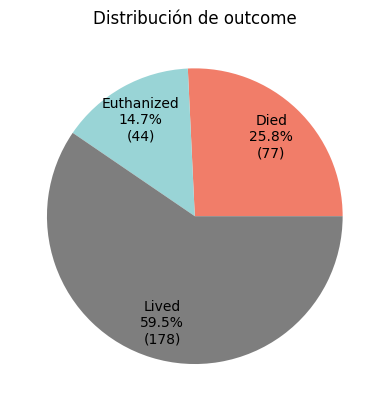

In [14]:
outcome_counts = horse_health['outcome'].value_counts()

fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(outcome_counts[labels], autopct='',
                                  colors=[custom_palette[label] for label in labels])

for wedge, label in zip(wedges, labels):
    count = outcome_counts.get(label, 0)
    percentage = (count / len(horse_health)) * 100
    angle = (wedge.theta2 - wedge.theta1) / 2.0 + wedge.theta1
    x = 0.75 * np.cos(np.deg2rad(angle))
    y = 0.75 * np.sin(np.deg2rad(angle))
    ax.text(x, y, f'{label.capitalize()}\n{percentage:.1f}%\n({count})', ha='center', va='center', fontsize=10)

plt.title('Distribución de outcome')
plt.show()

Conclusiones:

Se observa un desbalance entre los registros para cada una de las clases que toma la variable objetivo o target.

<u> Distribución de las features categóricas y de acuerdo a los grupos de clasificación del target 'outcome' 

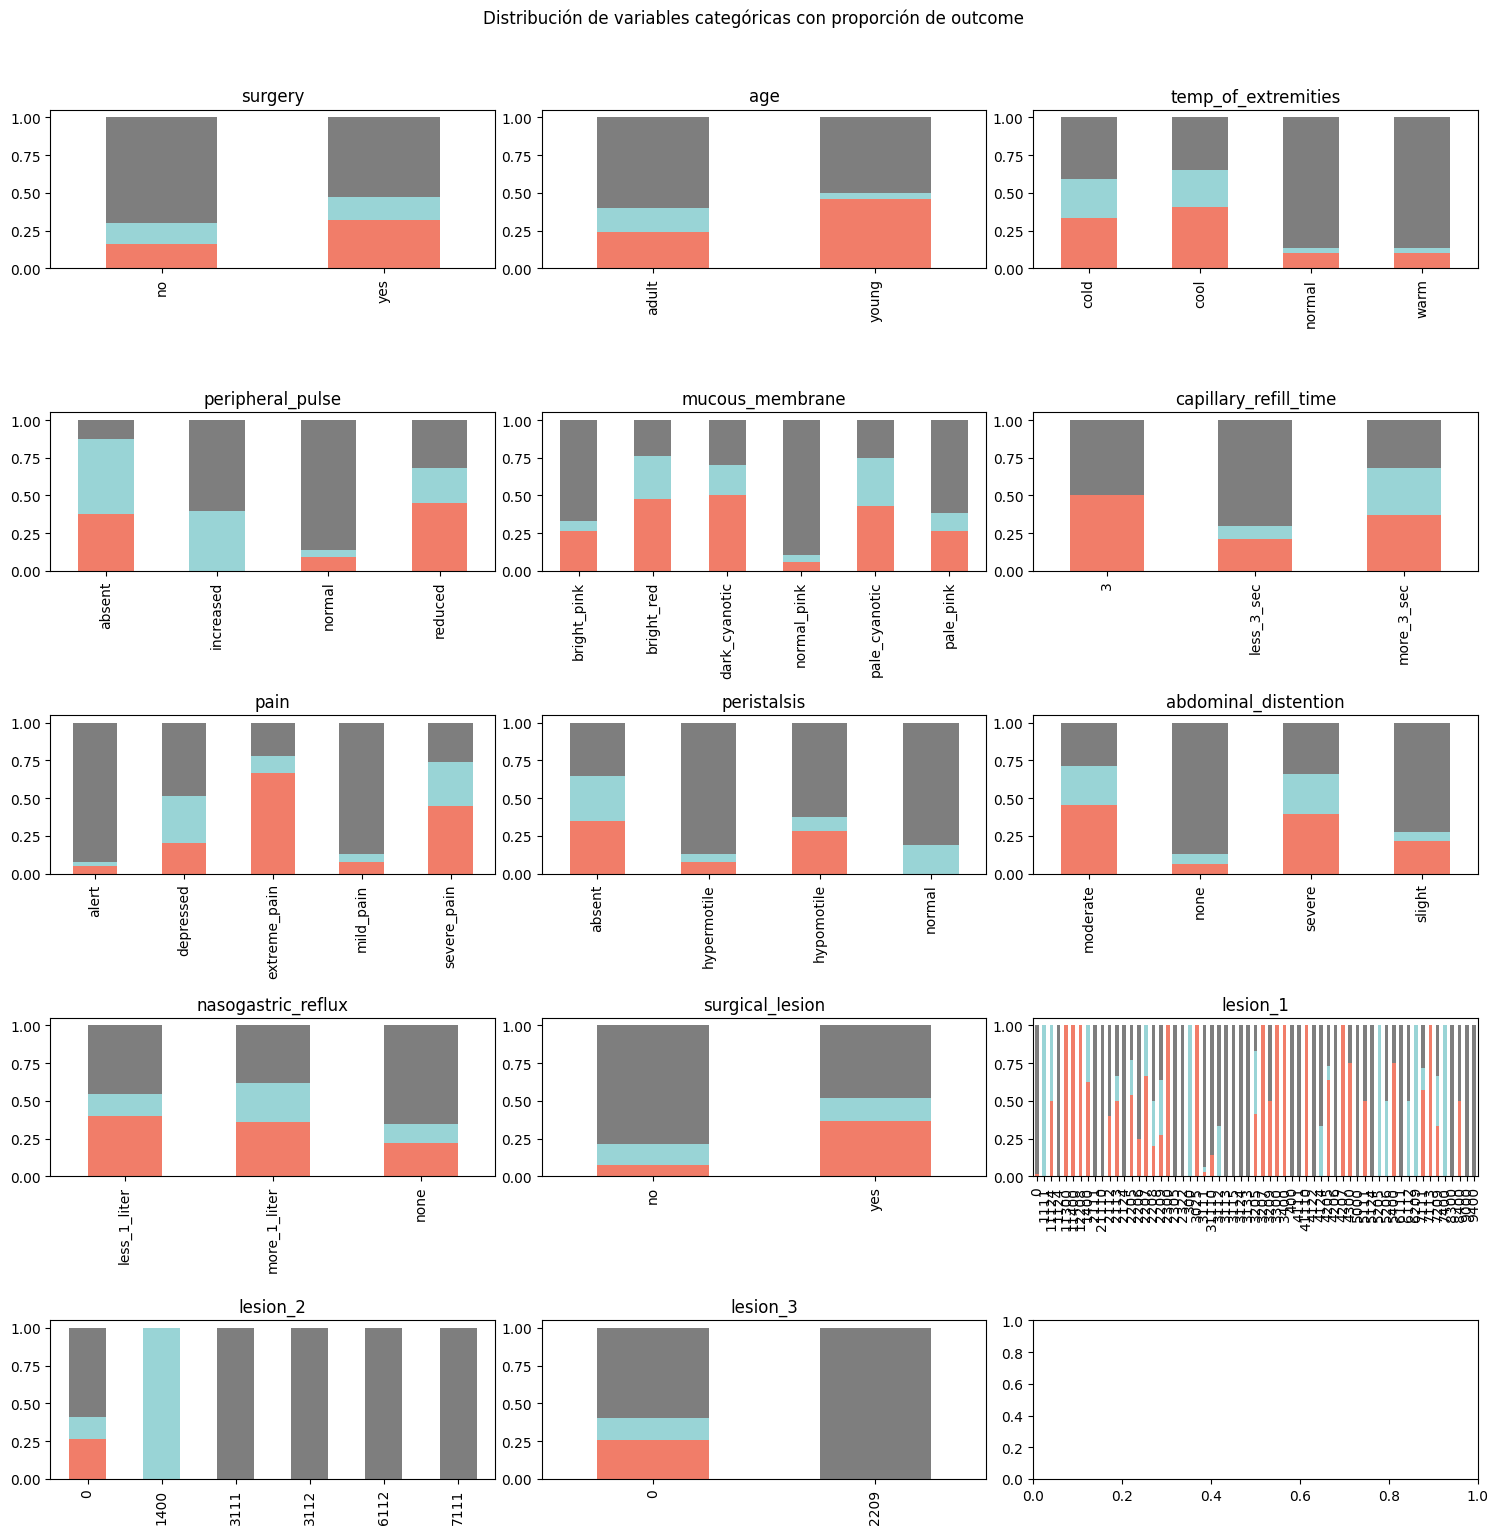

In [15]:
n = 3
num_rows = math.ceil(len(features_categoricas) / n)
fig, axes = plt.subplots(num_rows, n, figsize=(15, 3 * num_rows))

for i, feature in enumerate(features_categoricas):
    row = i // n
    col = i % n
    ax = axes[row, col] if num_rows > 1 else axes[col]
    
    # Crear un DataFrame para calcular la proporción de 'outcome' por categoría en la variable actual
    stacked_data = horse_health.groupby([feature, 'outcome']).size().unstack().fillna(0)
    stacked_data = stacked_data.div(stacked_data.sum(axis=1), axis=0)  # Calcular la proporción
    
    stacked_data.plot(kind='bar', stacked=True, color=[custom_palette[label] for label in stacked_data.columns], ax=ax)
    
    ax.set_title(feature)
    ax.set_xlabel('')
    ax.get_legend().remove()

plt.suptitle("Distribución de variables categóricas con proporción de outcome", y=1.02)
plt.tight_layout()
plt.show()

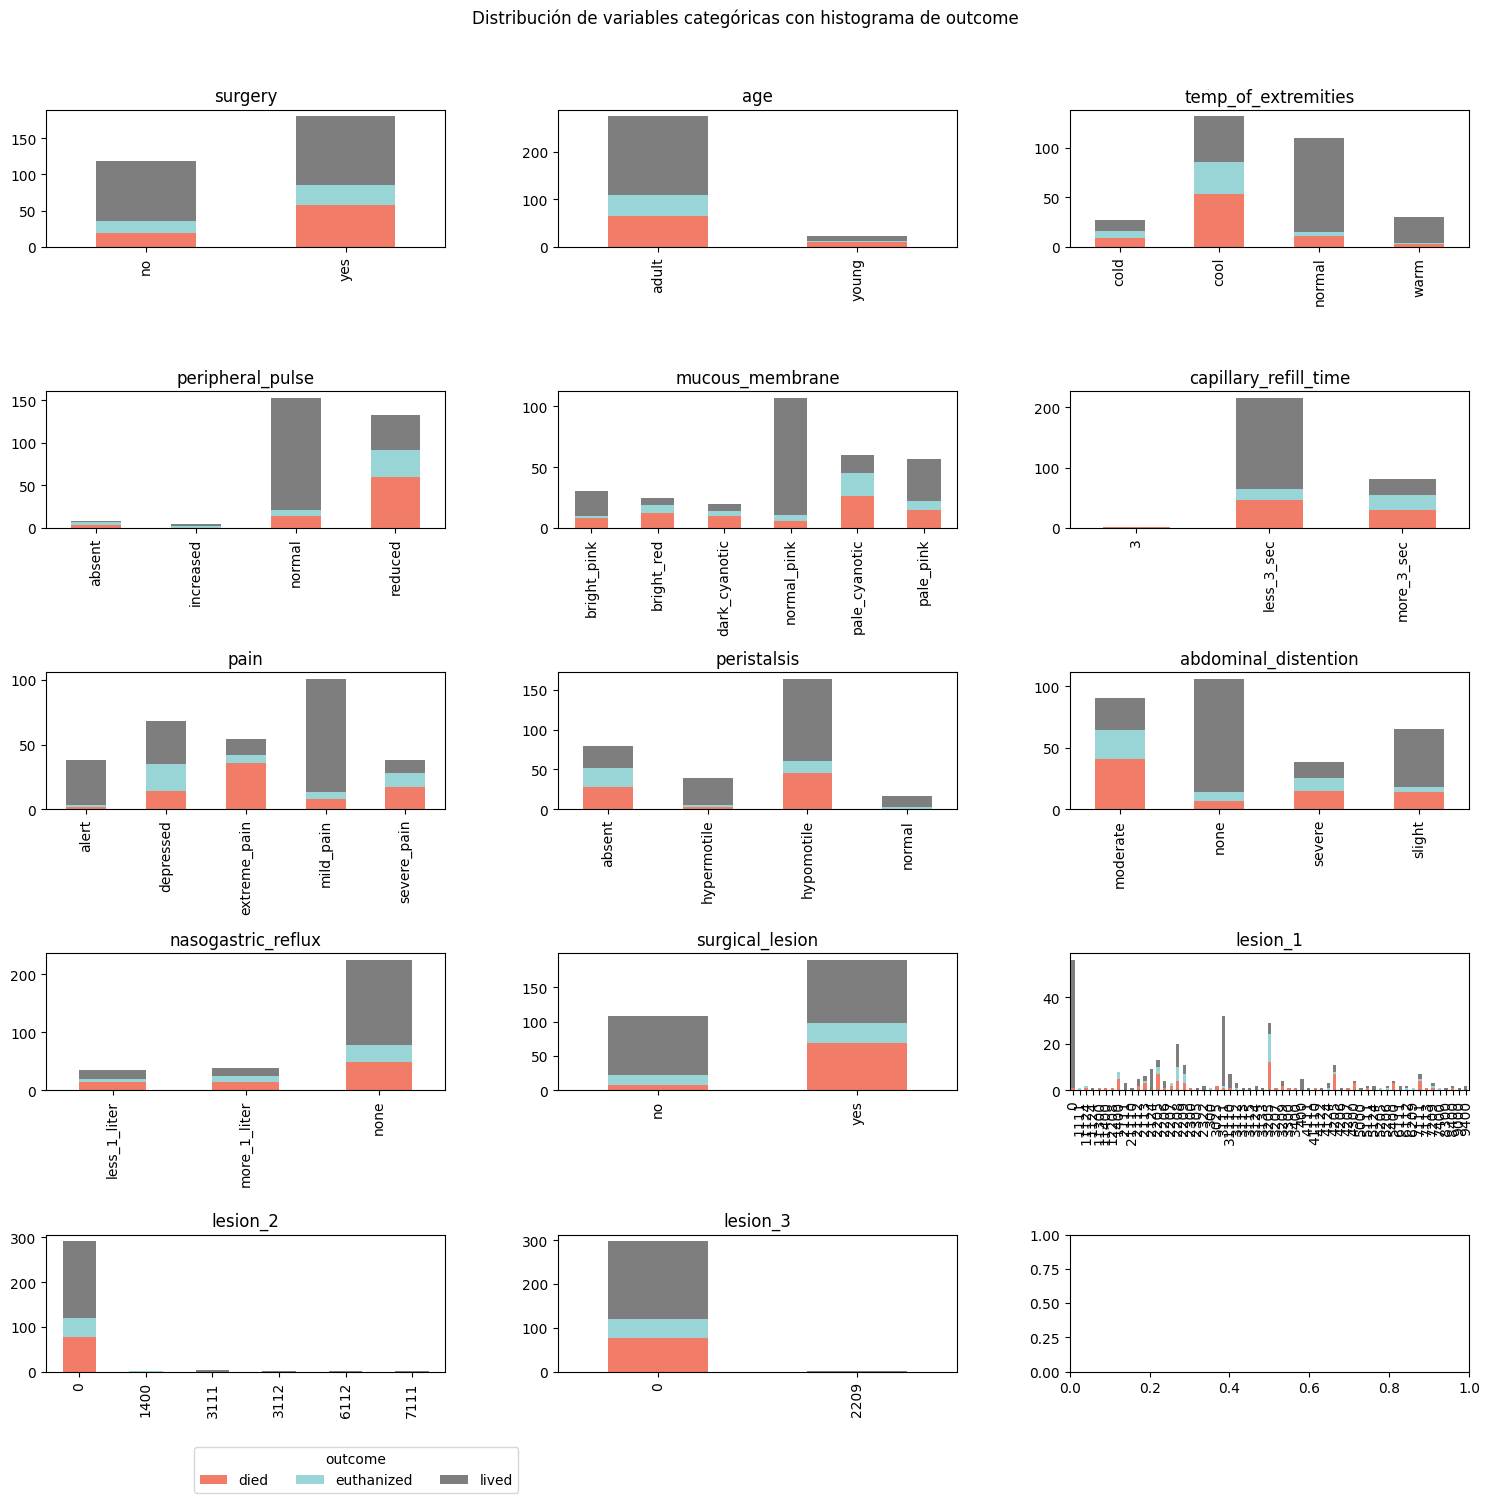

In [16]:
n = 3
num_rows = math.ceil(len(features_categoricas) / n)
fig, axes = plt.subplots(num_rows, n, figsize=(15, 3 * num_rows))

for i, feature in enumerate(features_categoricas):
    row = i // n
    col = i % n
    ax = axes[row, col] if num_rows > 1 else axes[col]
    
    # Crear un DataFrame para calcular la frecuencia de 'outcome' por categoría en la variable actual
    stacked_data = horse_health.groupby([feature, 'outcome']).size().unstack().fillna(0)
    
    stacked_data.plot(kind='bar', stacked=True, color=[custom_palette[label] for label in stacked_data.columns], ax=ax)
    
    ax.set_title(feature)
    ax.set_xlabel('')
    ax.get_legend().remove()

# Mostrar referencias en la parte inferior
axes[-1, 0].legend(title='outcome', loc='upper right', bbox_to_anchor=(1.2, -0.5), ncol=len(stacked_data.columns))

plt.suptitle("Distribución de variables categóricas con histograma de outcome", y=1.02)
plt.tight_layout()
plt.show()


Conclusiones:

En este caso, por la amplia variación de la cantidad de casos en cada categoría, es más elocuente el primer gráfico donde vemos la distribución proporcional. Siempre debemos recurrir al segundo para asegurarnos que el hecho de que en ciertos casos una distribución muy marcada de alguna caegoría podría deberse a una baja representatividad en cuanto a número de observaciones, por lo cual se recomienda referir también al segundo gráfico. 

Teniendo esto en cuenta, algunos parámetros clínicos y patológicos (lesiones) parecerían estar asociados a supervivencia (como niveles de dolor 'alert'/sin dolor y 'mild' o dolor leve, e indicadores de buena circulación periférica o perfusión como la temperatura normal de las extremidades, el tiempo de llenado capilar mínimo o el color de las mucosas). Todo esto tiene un correlato clínico, y cabe esperar que se vea reflejado a la hora de aplicar las etiquetas de predicción. Sin embargo, otros casos como tipos de lesiones particulares, la edad del paciente y la indicación de cirugía están más repartidos.

Anticipamos que la predicción de la categoría "euthanized" será dificultosa porque no se hallan marcadores distintivos, salvo el caso de la lesión puntual 1400. En otros casos se alinea, casi pareciera indistintamente, con las categorías "died" y "lived".

<u> Distribución de las features numéricas y de acuerdo a los grupos de clasificación del target 'outcome' 

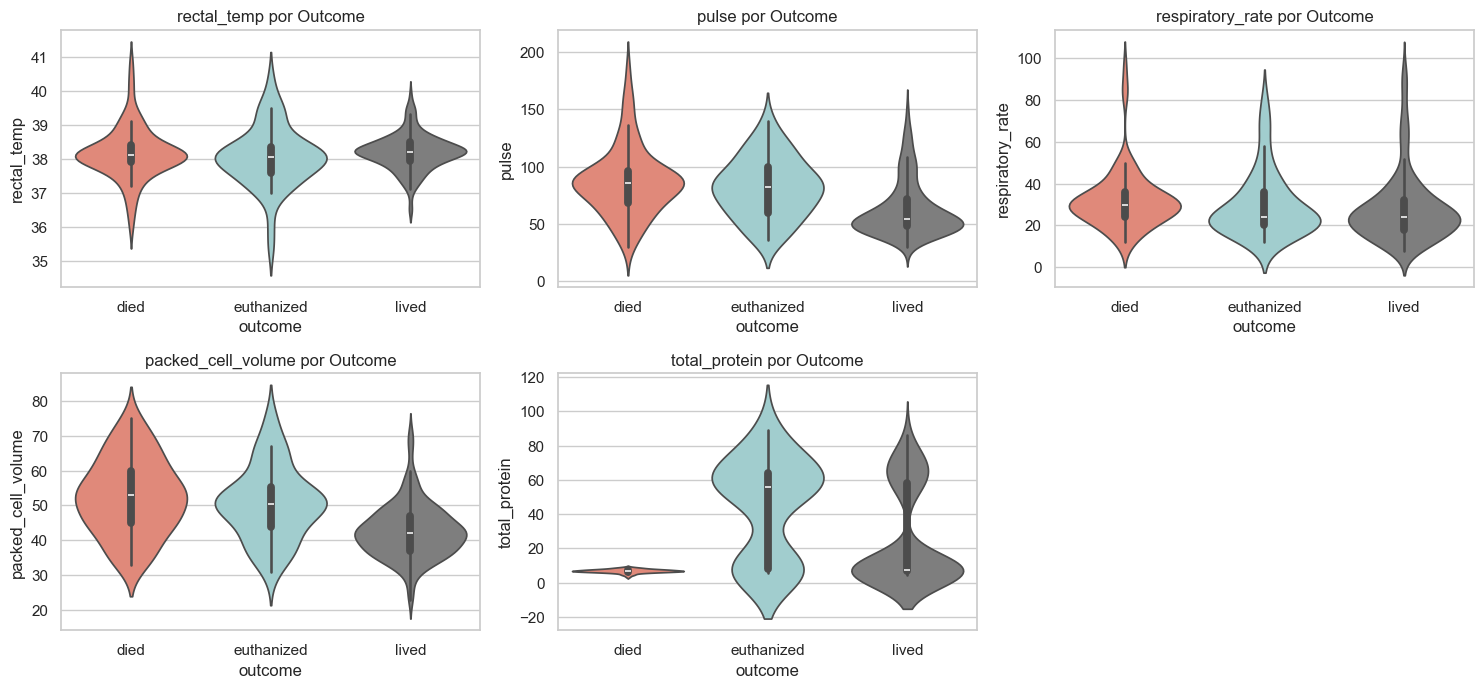

In [17]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(15, 10))

# Iterar sobre cada característica numérica y generar visualizaciones
for i, feature in enumerate(features_numericas, 1):
    plt.subplot(3, 3, i)  # 3x3 grid
    sns.violinplot(x='outcome', y=feature, data=horse_health, palette=custom_palette)
    plt.title(f'{feature} por Outcome')

plt.tight_layout()
plt.show()

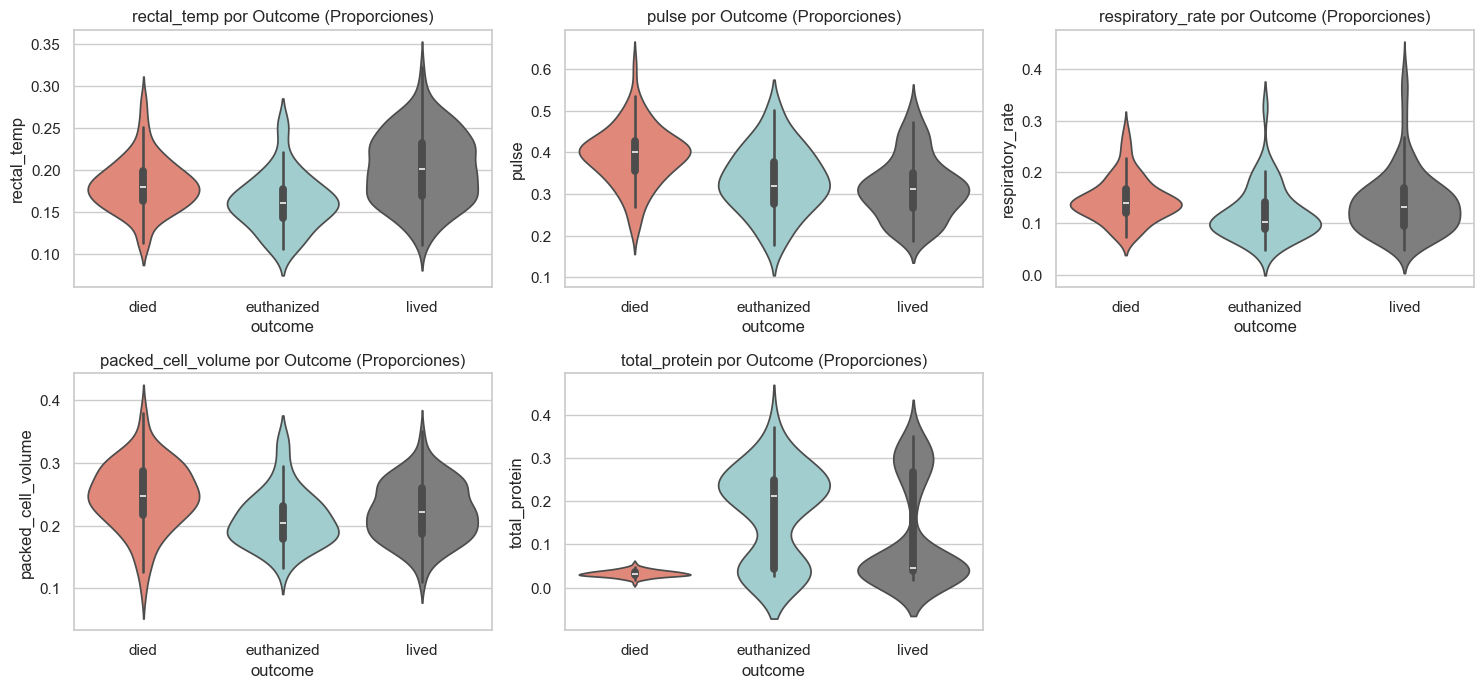

In [18]:
# Plots con las variables numéricas normalizadas
normalized_horse_health = horse_health.copy()
for outcome in horse_health['outcome'].unique():
    subset = horse_health[horse_health['outcome'] == outcome][features_numericas]
    total_sum = subset.sum(axis=1)
    for column in features_numericas:
        normalized_horse_health.loc[horse_health['outcome'] == outcome, column] /= total_sum

sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 10))

# Iterar sobre cada variable numérica y generar visualizaciones
for i, feature in enumerate(features_numericas, 1):
    plt.subplot(3, 3, i)
    sns.violinplot(x='outcome', y=feature, data=normalized_horse_health, palette=custom_palette)
    plt.title(f'{feature} por Outcome (Proporciones)')

plt.tight_layout()
plt.show()

Conclusiones:

La distribución de las variables numéricas entre las clases exhibe algunos patrones interesantes, por ejemplo a nivel de 'pulse' y 'packed cell volume'. Es llamativo que en muchos casos los valores de los equinos eutanasiados se asemejen más a los de los sobrevivientes que a los que murieron por causa del cólico, lo cual es esperable ya que esos animales podían no encontrarse en un estado de pérdida de las funciones fisiológicas o encontrarse en un estadío menos terminal al momento de tomarse la decisión. Recordemos que entre las variables categóricas analizadas se encuentran importantes marcadores de bienestar animal como el nivel de dolor y la lesión específica que causó el cólico, mientras que las variables cuantitativas analizadas son más generales.

- <U> Heatmap de correlaciones (Spearman) entre features y target

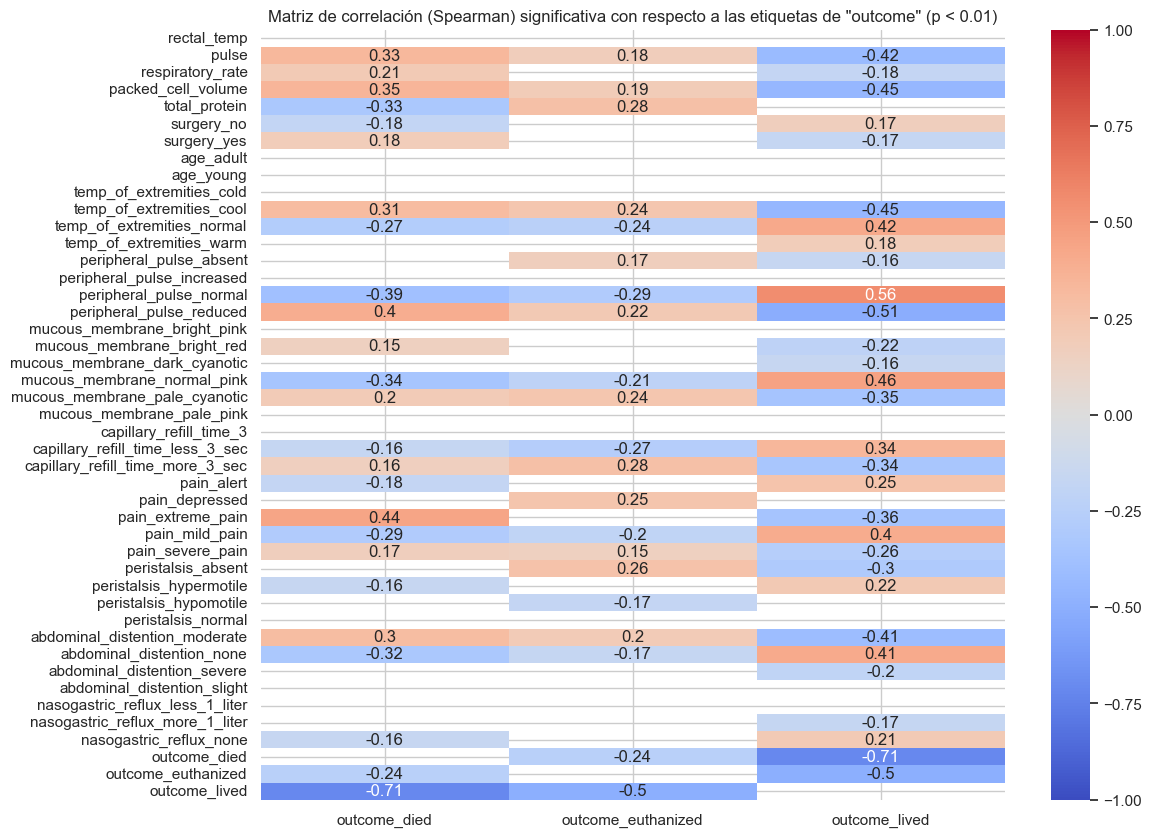

In [19]:
# Selección de columnas relevantes
selected_columns = ['surgery', 'age', 'rectal_temp', 'pulse', 'respiratory_rate', 'temp_of_extremities',
                    'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis',
                    'abdominal_distention', 'nasogastric_reflux', 'packed_cell_volume', 'total_protein',
                    'outcome']

horse_health_corr = horse_health[selected_columns]

# Codificar variables categóricas
horse_health_corr = pd.get_dummies(horse_health_corr)

# Calcular la matriz de correlación utilizando Spearman
corr_matrix = horse_health_corr.corr(method='spearman')

# Calcular los valores p para cada correlación
p_values = pd.DataFrame(index=corr_matrix.columns, columns=corr_matrix.columns)
for i in corr_matrix.columns:
    for j in corr_matrix.columns:
        rho, p = spearmanr(horse_health_corr[i], horse_health_corr[j])
        p_values.loc[i, j] = p

# Filtrar la matriz de correlación para incluir solo las características con correlaciones significativas (p < 0.05)
significant_corr_matrix = corr_matrix[((p_values < 0.01) & (p_values > 0)) | ((p_values > -0.01) & (p_values < 0))]

# Configurar el tamaño de la figura
plt.figure(figsize=(12, 10))

# Visualizar la matriz de correlación filtrada utilizando un mapa de calor
sns.heatmap(significant_corr_matrix[['outcome_died', 'outcome_euthanized', 'outcome_lived']], 
            cmap='coolwarm', vmin=-1, vmax=1, annot=True)

# Configurar título y mostrar el mapa de calor
plt.title('Matriz de correlación (Spearman) significativa con respecto a las etiquetas de "outcome" (p < 0.01)')
plt.show()

Conclusiones:

En este gráfico podemos observar varias relaciones interesantes, con algunos outcomes en particular. Procederemos a realizar un perfilado desde el punto de vista veterinario del paciente que pareciera estar más representado en cada caso.

- Outcome_died: esta etiqueta se correlaciona positivamente con el dolor extremo ('pain_extreme_pain'), con el pulso periférico reducido ('peripheral_pulse_reduced') y las extremidades ligeramente frías ('temp_of_extremities_cool'). Asimismo, también exhibe una correlación positiva con un pulso alto (¿dolor?) y un hematocrito o concentración de hematíes alta ('packed_cell_volume'), que evidencia deshidratación. Todo esto indica un estadío de shock o falla multiorgánica propia de un cólico agudo terminal. Por otro lado, existen correlaciones negativas con parámetros clínicos normales/fisiológicos favorables como temperatura y pulso periféricos normales, mucosas rosadas, ausencia de distensión abdominal, y ausencia de pérdida de proteínas.

- Outcome_euthanized: es interesante evaluar esta etiqueta, porque los motivadores de la decisión de eutanasiar al paciente pueden ser bien diferentes a las causas de muerte espontánea. En este caso, observamos una correlación positiva con depresión del sensorio ('pain_depressed'), reducción del pulso periférico ('peripheral_pulse_reduced'), peristalsis ausente que marca contenido gaseoso o falla gastrointestinal ('peristalsis_absent), tiempo de llenado capilar superior a tres segundos ('capillary_refill_time_more_3_sec), membranas mucosas cianóticas/ violáceas ('mucous_membrane_cyanotic'), estos dos últimos signo de anemia severa. Todos estos signos nos llevan a pensar en un paciente profundamente deprimido, anémico, y con una apreciable disminución de su función orgánica. Sin embargo, a diferencia del caso anterior, son correlaciones más débiles. Sería interesante realizar evaluaciones de un mayor número de pacientes para determinar si esta tendencia se vuelve más marcada. Una vez más, las correlaciones negativas se dan con parámetros normales/ fisiológicos.

- Outcome_lived: Los caballos que sobrevivieron presentan, de acuerdo con estas correlaciones, una mayor probabilidad de presentar dolor leve / ausente (no olvidemos que todos los equinos de la base de datos son pacientes de cólico, una condición clínica generalmente dolorosa), ausencia de distensión abdominal, pulso normal, mucosas rosadas normales, temperatura de las extremidades normal y tiempo de llenado capilar menor a 3 segundos (mostrando una circulación periférica normal). Por lo tanto, prevemos que los parámetros clínicos que se relacionan con una hemodinamia normal y un sensorio alerta serán de importancia a la hora de determinar el éxito del cuadro clínico. De todos modos, recordemos que las categorías que nos resultan más interesantes para el objetivo de nuestro modelo predictivo son las otras dos etiquetas, por lo cual haremos hincapié en las mismas.

<u> PairPlot entre features cuantitativas agrupando los resultados por etiqueta de 'outcome'

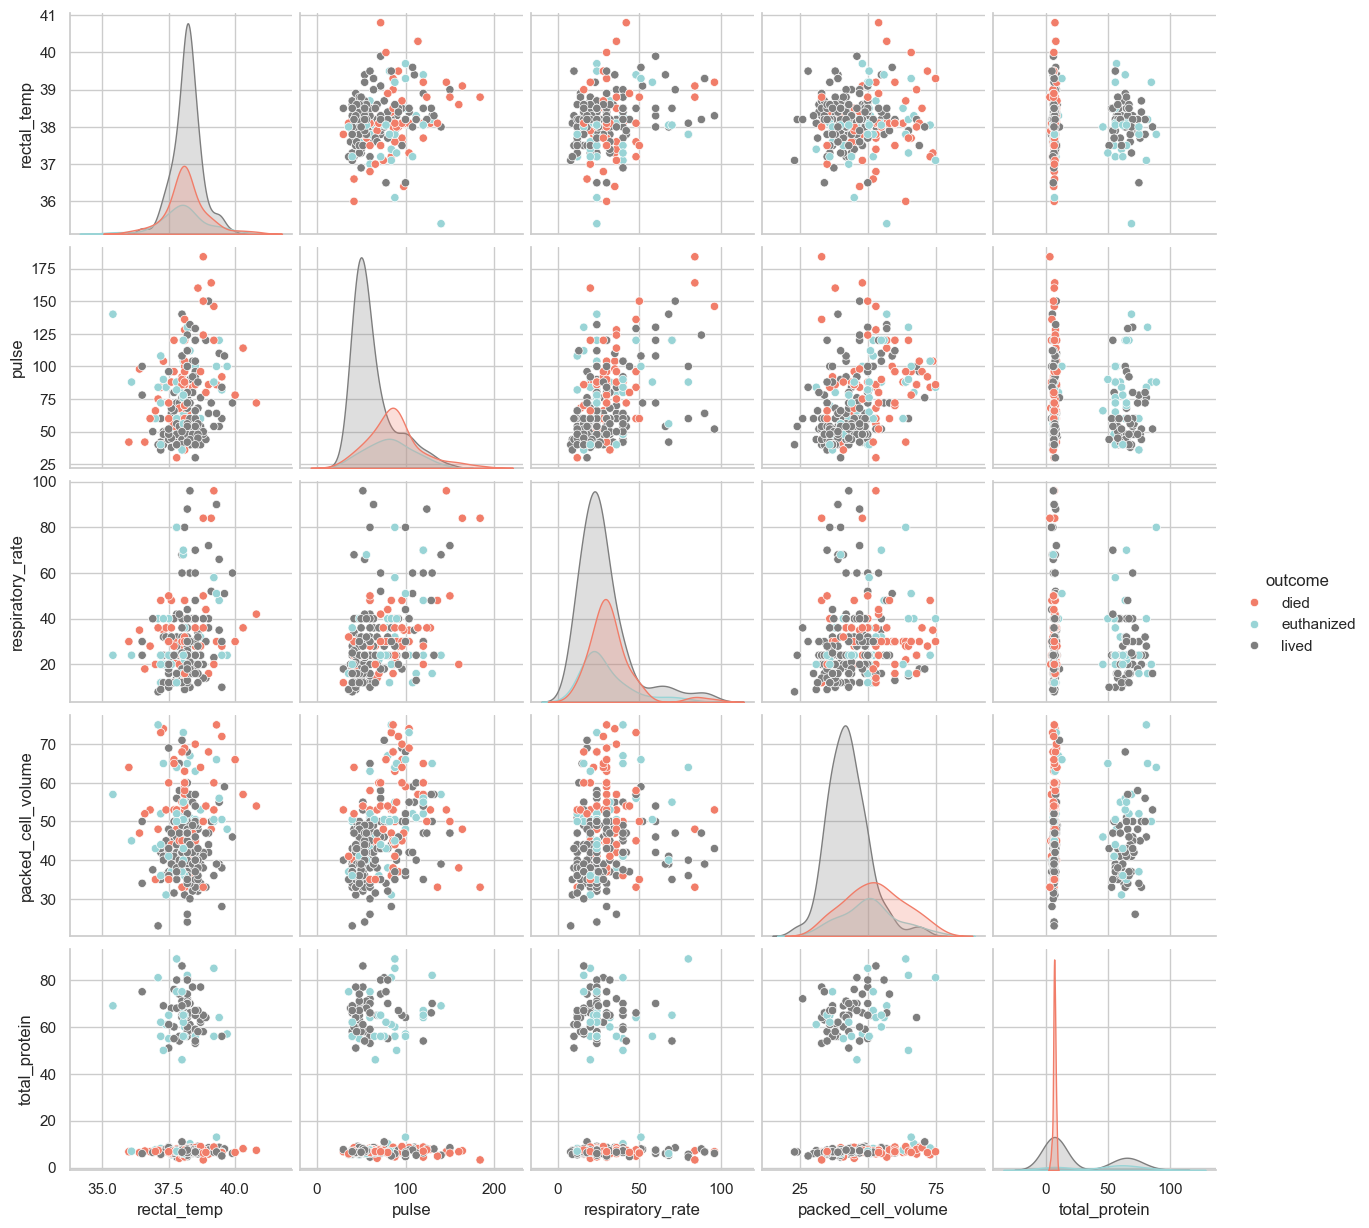

In [20]:
sns.pairplot(horse_health, hue='outcome', palette=custom_palette)

Conclusiones:

El pairplot nos confirma algunas de las asociaciones que observamos entre las variables clínicas (features) y el resultado target, sin embargo no observamos entre los pares de variables una división clara entre los puntos de cada resultado o 'outcome'. Los histogramas en la diagonal son elocuentes en cuantoa a diferencias en las distribuciones de las variables agrupadas por target (ej. 'packed cell volume', 'pulse').

<h2 style="font-style: italic;">Preprocesamiento</h2>

- Construimos una función que nos permita calcular y visualizar fácilmente los resultados de cada modelo

In [21]:
def Classification_Summary(y_pred,pred_prob,i):
    print('Accuracy = {}%'.format(round(accuracy_score(y_test, y_pred),3)*100))
    print('F1 Score = {}%'.format(round(f1_score(y_test, y_pred, average='weighted'),3)*100)) #
    print('\n \033[1mConfusion Matrix:\033[0m\n',confusion_matrix(y_test, y_pred))
    print('\n\033[1mClassification Report:\033[0m\n',classification_report(y_test, y_pred))
    
    auc_roc(y_test, pred_prob, curves=['each_class'])
    plt.show()

- Construimos una función para evaluar el rendimiento computacional de cada modelo

In [22]:
def start_evaluation():
    # Medir el tiempo de ejecución
    start_time = time.time()
    
    # Medir el uso de memoria antes del entrenamiento
    memory_before = psutil.Process().memory_info().rss / 1024  # Convertir a kilobytes
    
    return start_time, memory_before

def end_evaluation(start_time, memory_before, model, X_test):
    # Medir el uso de memoria después del entrenamiento
    memory_after = psutil.Process().memory_info().rss / 1024  # Convertir a kilobytes
    
    # Calcular el tiempo de entrenamiento
    training_time = time.time() - start_time
    
    # Obtener el tamaño del modelo
    model_size = sys.getsizeof(model) / (1024 * 1024)  # Convertir a megabytes
    
    # Imprimir resultados
    print("Tiempo de entrenamiento:", training_time, "segundos")
    print("Uso de memoria antes del entrenamiento:", memory_before, "KB")
    print("Uso de memoria después del entrenamiento:", memory_after, "KB")
    print("Tamaño del modelo:", model_size, "MB")

- Preparación de las variables categóricas y encoding (codificación)

Se generan diferentes listados de agrupación para reflejar la naturaleza de cada feature. En el caso de las ordinales, se crean diccionarios para asignar valores numéricos que reflejen su orden. Se aplica el mapeo a las variables ordinales en el subconjunto features_ordinales, sustituyendo las categorías originales por sus equivalentes numéricos según los diccionarios de mapeo.

Finalmente, se dividen las features en grupos para poder llamarlos fácilmente al momento de realizar el encoding.

In [23]:
nominal_vars = ['mucous_membrane', 'pain', 'lesion_1', 'lesion_2', 'lesion_3']
ordinal_vars = ['abdominal_distention', 'capillary_refill_time', 'nasogastric_reflux', 'peristalsis', 'temp_of_extremities', 'peripheral_pulse']
binary_vars = ['surgery', 'surgical_lesion', 'age']

# Diccionarios de mapeo para features ordinales
abdominal_distention_mapping = {'none': 0, 'slight': 1, 'moderate': 2, 'severe': 3}
capillary_refill_time_mapping = {'less_3_sec': 0, '3': 1, 'more_3_sec': 2}
nasogastric_reflux_mapping = {'none': 0, 'less_1_liter': 1, 'more_1_liter': 2}
peristalsis_mapping = {'absent': 0, 'hypomotile': 1, 'normal': 2, 'hypermotile': 3}
temp_of_extremities_mapping = {'cold': 0, 'cool': 1, 'normal': 2, 'warm': 3}
peripheral_pulse_mapping = {'absent': 0, 'reduced': 1, 'normal': 2, 'increased': 3}

#Creamos subsets para los diferentes tipos de encoding
features_nominales = horse_health[features_categoricas][nominal_vars]
features_ordinales = horse_health[features_categoricas][ordinal_vars]
features_binarias = horse_health[features_categoricas][binary_vars]

# Aplicar el mapeo a las features ordinales
features_ordinales['abdominal_distention'] = features_ordinales['abdominal_distention'].map(abdominal_distention_mapping)
features_ordinales['capillary_refill_time'] = features_ordinales['capillary_refill_time'].map(capillary_refill_time_mapping)
features_ordinales['nasogastric_reflux'] = features_ordinales['nasogastric_reflux'].map(nasogastric_reflux_mapping)
features_ordinales['peristalsis'] = features_ordinales['peristalsis'].map(peristalsis_mapping)

In [24]:
# One-hot encoding - nominales
nominal_encoder = OneHotEncoder(drop='first', sparse=False)
features_nominales_encoded = pd.DataFrame(nominal_encoder.fit_transform(features_nominales), columns=nominal_encoder.get_feature_names_out(nominal_vars))

# Ordinal encoding - ordinales
ordinal_encoder = OrdinalEncoder()
features_ordinales_encoded = pd.DataFrame(ordinal_encoder.fit_transform(features_ordinales), columns=ordinal_vars)

# Binary encoding - binarias
binary_encoder = BinaryEncoder()
features_binarias_encoded = binary_encoder.fit_transform(features_binarias)

horse_health = horse_health.drop(nominal_vars + ordinal_vars + binary_vars, axis=1)
horse_health = pd.concat([horse_health, features_nominales_encoded, features_ordinales_encoded, features_binarias_encoded], axis=1)

In [25]:
print("Encoding features nominales:")
features_nominales_encoded.head()

Encoding features nominales:


,mucous_membrane_bright_red,mucous_membrane_dark_cyanotic,mucous_membrane_normal_pink,mucous_membrane_pale_cyanotic,mucous_membrane_pale_pink,pain_depressed,pain_extreme_pain,pain_mild_pain,pain_severe_pain,lesion_1_1111,...,lesion_1_8300,lesion_1_8400,lesion_1_9000,lesion_1_9400,lesion_2_1400,lesion_2_3111,lesion_2_3112,lesion_2_6112,lesion_2_7111,lesion_3_2209
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
print("\nEncoding features ordinales:")
features_ordinales_encoded.head()


Encoding features ordinales:


,abdominal_distention,capillary_refill_time,nasogastric_reflux,peristalsis,temp_of_extremities,peripheral_pulse
0,3.0,2.0,0.0,0.0,1.0,3.0
1,1.0,0.0,0.0,0.0,1.0,3.0
2,0.0,0.0,0.0,1.0,2.0,2.0
3,3.0,2.0,1.0,0.0,0.0,2.0
4,2.0,2.0,0.0,1.0,1.0,3.0


In [27]:
print("\nEncoding features binarias:")
features_binarias_encoded.head()


Encoding features binarias:


,surgery_0,surgery_1,surgical_lesion_0,surgical_lesion_1,age_0,age_1
0,0,1,0,1,0,1
1,1,0,0,1,0,1
2,0,1,0,1,0,1
3,1,0,1,0,1,0
4,0,1,0,1,0,1


Observamos que los dos últimos tipos de encoding no genera una variable por cada variante.

- Definimos X e y, generamos subconjuntos de entrenamiento y prueba (para todas las variables consideradas)

In [28]:
X = horse_health.drop(['outcome'], axis=1)
y = horse_health['outcome']

In [29]:
X.sample()

,rectal_temp,pulse,respiratory_rate,packed_cell_volume,total_protein,mucous_membrane_bright_red,mucous_membrane_dark_cyanotic,mucous_membrane_normal_pink,mucous_membrane_pale_cyanotic,mucous_membrane_pale_pink,...,nasogastric_reflux,peristalsis,temp_of_extremities,peripheral_pulse,surgery_0,surgery_1,surgical_lesion_0,surgical_lesion_1,age_0,age_1
207,37.8,88.0,80.0,64.0,89.0,1.0,0.0,0.0,0.0,0.0,...,2.0,1.0,1.0,3.0,1,0,1,0,0,1


<h2 style="font-style: italic;">Modelo de Naive Bayes</h2>

Decidimos utilizar Naive Bayes Complementario, que dentro de esta familia de modelos es el que se ajusta mejor al tipo de features (con una proporción significativa de variables categóricas, y un gran desbalance en la distribución de las clases).

A pesar de que no se verifica la independencia de las variables (sino que al tratarse de una patología con falla multisistémica se encuentran íntimamente relacionadas o responden a causas comunes), comenzamos con un modelo de prueba contemplando a todas las features iniciales.

In [30]:
#Definición del modelo
NB_model = ComplementNB()

- Modelo de Naive Bayes tomando todas las features iniciales
---

Separamos los datos en conjuntos de train y test utilizando estratificación para intentar manejar el desbalance entre clases del target.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, stratify=y, random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(194, 92)
(105, 92)
(194,)
(105,)


Elegimos escalar las medidas cuantitativas a través de MinMax Scaler, ya que Naive Bayes no acepta valores negativos

In [32]:
scaler = MinMaxScaler()

# Features - entrenamiento/train
X_train[features_numericas] = scaler.fit_transform(X_train[features_numericas])

# Features - prueba/test
X_test[features_numericas] = scaler.transform(X_test[features_numericas])

In [33]:
#Corroboramos la nueva escala de las features de entrenamiento
X_train.describe()

,rectal_temp,pulse,respiratory_rate,packed_cell_volume,total_protein,mucous_membrane_bright_red,mucous_membrane_dark_cyanotic,mucous_membrane_normal_pink,mucous_membrane_pale_cyanotic,mucous_membrane_pale_pink,...,nasogastric_reflux,peristalsis,temp_of_extremities,peripheral_pulse,surgery_0,surgery_1,surgical_lesion_0,surgical_lesion_1,age_0,age_1
count,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,...,194.000000,194.00000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000
mean,0.506777,0.314948,0.222953,0.457062,0.248220,0.092784,0.067010,0.345361,0.206186,0.201031,...,0.355670,1.00000,1.448454,2.365979,0.597938,0.402062,0.628866,0.371134,0.056701,0.943299
std,0.117356,0.199584,0.160089,0.200414,0.330633,0.290879,0.250687,0.476716,0.405612,0.401808,...,0.699588,0.89905,0.768501,0.679132,0.491583,0.491583,0.484358,0.484358,0.231869,0.231869
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.462963,0.153846,0.126437,0.305000,0.026994,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.509259,0.261538,0.172414,0.420000,0.036810,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.00000,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,0.555556,0.446154,0.264368,0.580000,0.631902,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,1.00000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,2.000000,3.00000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Ajuste de los datos al modelo

In [34]:
start_time, memory_before = start_evaluation()

Valor óptimo de alpha: 0.01
Accuracy = 76.2%
F1 Score = 74.2%

 Confusion Matrix:
 [[20  1  6]
 [ 9  3  3]
 [ 4  2 57]]

Classification Report:
               precision    recall  f1-score   support

        died       0.61      0.74      0.67        27
  euthanized       0.50      0.20      0.29        15
       lived       0.86      0.90      0.88        63

    accuracy                           0.76       105
   macro avg       0.66      0.62      0.61       105
weighted avg       0.75      0.76      0.74       105



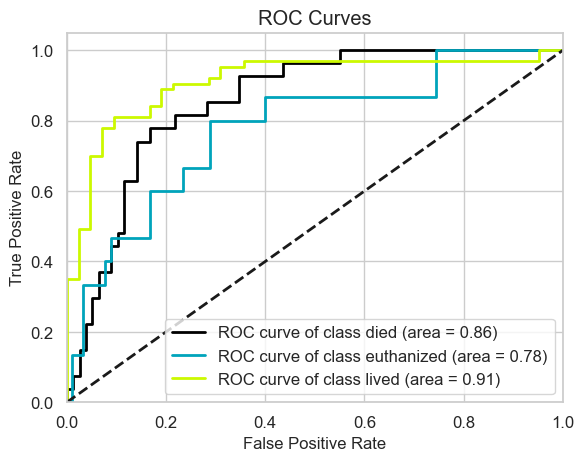

In [35]:
# Entrenar el modelo con GridSearchCV
params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

GCV = GridSearchCV(NB_model, params, scoring='roc_auc', n_jobs=-1, cv=cv)
GCV.fit(X_train, y_train)

# Mejor estimador
best_NB_model = GCV.best_estimator_
print(f"Valor óptimo de alpha: {best_NB_model.alpha}")

# Predecir y calcular probabilidades
y_pred = best_NB_model.predict(X_test)
pred_prob = best_NB_model.predict_proba(X_test)

# Función resumen resultados
Classification_Summary(y_pred, pred_prob, 3)

In [36]:
end_evaluation(start_time, memory_before, NB_model, X_test)

Tiempo de entrenamiento: 11.289823770523071 segundos
Uso de memoria antes del entrenamiento: 268792.0 KB
Uso de memoria después del entrenamiento: 270932.0 KB
Tamaño del modelo: 4.57763671875e-05 MB


A modo de prueba intentamos otra estrategia de cross validation para datos desbalanceados, Stratified Shuffle Splits, que aleatoriza la partición entre datos de entrenamiento y prueba en cada repetición. Con respecto a Repeated Stratified K Fold, es levemente más eficiente a nivel computacional.
Como se puede observar a continuación, el resultado en este caso es idéntico al obtenido ya que se busca un sólo parámetro (alpha) y el resultado es el mismo.

In [37]:
start_time, memory_before = start_evaluation()

Valor óptimo de alpha: 0.01
Accuracy = 76.2%
F1 Score = 74.2%

 Confusion Matrix:
 [[20  1  6]
 [ 9  3  3]
 [ 4  2 57]]

Classification Report:
               precision    recall  f1-score   support

        died       0.61      0.74      0.67        27
  euthanized       0.50      0.20      0.29        15
       lived       0.86      0.90      0.88        63

    accuracy                           0.76       105
   macro avg       0.66      0.62      0.61       105
weighted avg       0.75      0.76      0.74       105



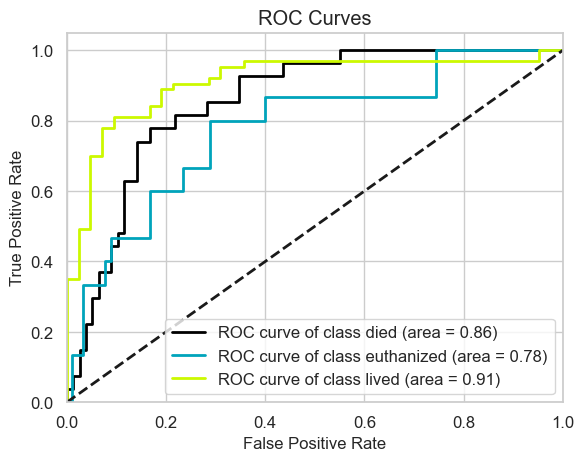

In [38]:
# Entrenar el modelo con GridSearchCV
cv2 = StratifiedShuffleSplit(n_splits=10, random_state=1)

GCV = GridSearchCV(NB_model, params, scoring='roc_auc', n_jobs=-1, cv=cv2)
GCV.fit(X_train, y_train)

# Mejor estimador
best_NB_model = GCV.best_estimator_
print(f"Valor óptimo de alpha: {best_NB_model.alpha}")

# Predecir y calcular probabilidades
y_pred = best_NB_model.predict(X_test)
pred_prob = best_NB_model.predict_proba(X_test)

# Función resumen resultados
Classification_Summary(y_pred, pred_prob, 3)

In [39]:
end_evaluation(start_time, memory_before, NB_model, X_test)

Tiempo de entrenamiento: 1.5373120307922363 segundos
Uso de memoria antes del entrenamiento: 270932.0 KB
Uso de memoria después del entrenamiento: 272888.0 KB
Tamaño del modelo: 4.57763671875e-05 MB


- NB alternativo 1: Selección de las variables menos relacionadas en base a criterio clínico
---

In [40]:
start_time, memory_before = start_evaluation()

In [41]:
# Copia de trabajo
horse_health_NB1 = horse_health.copy()

# Seleccionar y eliminar columnas
columns_to_drop = ['outcome', 'pulse', 'respiratory_rate', 'packed_cell_volume', 'capillary_refill_time', 'nasogastric_reflux',
                   'peristalsis', 'temp_of_extremities', 'surgery_0', 'surgery_1', 'lesion_1_1111', 'lesion_1_11124', 'lesion_1_1124',
                   'lesion_1_11300', 'lesion_1_11400', 'lesion_1_12208', 'lesion_1_1400', 'lesion_1_2111', 'lesion_1_21110', 'lesion_1_2112',
                   'lesion_1_2113', 'lesion_1_2124', 'lesion_1_2205', 'lesion_1_2206', 'lesion_1_2207', 'lesion_1_2208', 'lesion_1_2209',
                   'lesion_1_2300', 'lesion_1_2305', 'lesion_1_2322', 'lesion_1_300', 'lesion_1_3025', 'lesion_1_3111', 'lesion_1_31110',
                   'lesion_1_3112', 'lesion_1_3113', 'lesion_1_3115', 'lesion_1_3124', 'lesion_1_3133', 'lesion_1_3205', 'lesion_1_3207',
                   'lesion_1_3209', 'lesion_1_3300', 'lesion_1_3400', 'lesion_1_400', 'lesion_1_4111', 'lesion_1_41110', 'lesion_1_4122',
                   'lesion_1_4124', 'lesion_1_4205', 'lesion_1_4206', 'lesion_1_4207', 'lesion_1_4300', 'lesion_1_5000', 'lesion_1_5111',
                   'lesion_1_5124', 'lesion_1_5205', 'lesion_1_5206', 'lesion_1_5400', 'lesion_1_6111', 'lesion_1_6112', 'lesion_1_6209',
                   'lesion_1_7111', 'lesion_1_7113', 'lesion_1_7209', 'lesion_1_7400', 'lesion_1_8300', 'lesion_1_8400', 'lesion_1_9000',
                   'lesion_1_9400', 'lesion_2_1400', 'lesion_2_3111', 'lesion_2_3112', 'lesion_2_6112', 'lesion_2_7111', 'lesion_3_2209']

X_NB1 = horse_health_NB1.drop(columns=columns_to_drop)

In [42]:
X_NB1.columns

Index(['rectal_temp', 'total_protein', 'mucous_membrane_bright_red',
       'mucous_membrane_dark_cyanotic', 'mucous_membrane_normal_pink',
       'mucous_membrane_pale_cyanotic', 'mucous_membrane_pale_pink',
       'pain_depressed', 'pain_extreme_pain', 'pain_mild_pain',
       'pain_severe_pain', 'abdominal_distention', 'peripheral_pulse',
       'surgical_lesion_0', 'surgical_lesion_1', 'age_0', 'age_1'],
      dtype='object')

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_NB1, y, test_size=0.35, stratify=y, random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(194, 17)
(105, 17)
(194,)
(105,)


In [44]:
features_numericas_NB1 = ['rectal_temp', 'total_protein']

scaler = MinMaxScaler()

# Features - entrenamiento/train
X_train[features_numericas_NB1] = scaler.fit_transform(X_train[features_numericas_NB1])

# Features - prueba/test
X_test[features_numericas_NB1] = scaler.transform(X_test[features_numericas_NB1])

Valor óptimo de alpha: 0.01
Accuracy = 71.39999999999999%
F1 Score = 70.6%

 Confusion Matrix:
 [[20  2  5]
 [ 9  3  3]
 [ 7  4 52]]

Classification Report:
               precision    recall  f1-score   support

        died       0.56      0.74      0.63        27
  euthanized       0.33      0.20      0.25        15
       lived       0.87      0.83      0.85        63

    accuracy                           0.71       105
   macro avg       0.59      0.59      0.58       105
weighted avg       0.71      0.71      0.71       105



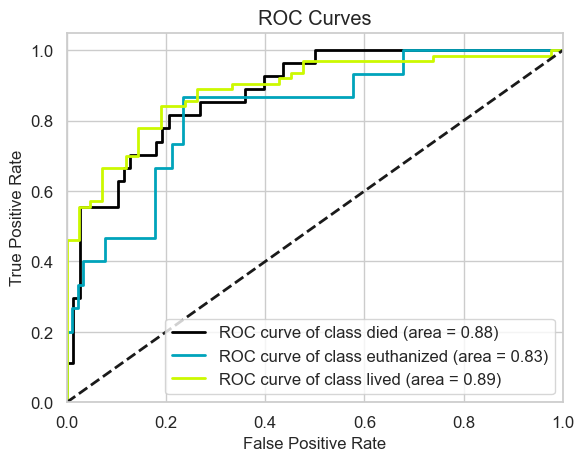

In [45]:
#Repetimos el procedimiento de puesta a punto

# Entrenar el modelo con GridSearchCV
params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

GCV = GridSearchCV(NB_model, params, scoring='roc_auc', n_jobs=-1, cv=cv)
GCV.fit(X_train, y_train)

# Mejor estimador
best_NB_model = GCV.best_estimator_
print(f"Valor óptimo de alpha: {best_NB_model.alpha}")

# Predecir y calcular probabilidades
y_pred = best_NB_model.predict(X_test)
pred_prob = best_NB_model.predict_proba(X_test)

# Función resumen resultados
Classification_Summary(y_pred, pred_prob, 3)

In [46]:
end_evaluation(start_time, memory_before, NB_model, X_test)

Tiempo de entrenamiento: 1.7624680995941162 segundos
Uso de memoria antes del entrenamiento: 272888.0 KB
Uso de memoria después del entrenamiento: 273472.0 KB
Tamaño del modelo: 4.57763671875e-05 MB


- NB alternativo 2: Tomamos las variables feature más distantes + agrupar animales muertos y eutanasiados
---

Esta alternativa, al agrupar dos de las labels de la variable target, lleva a una pérdida de información importante (ver introducción del trabajo) pero puede ser un modelo de buen desempeño y bajo costo de procesamiento si se escala a una muestra de caballos mayor.

In [47]:
start_time, memory_before = start_evaluation()

In [48]:
# Copia de trabajo
horse_health_NB2 = horse_health.copy()

# Se combinan las categorías "euthanized" y "died" en "not alive"
horse_health_NB2['outcome'] = horse_health_NB2['outcome'].replace({'died': 'not alive', 'euthanized': 'not alive'})

print(horse_health_NB2['outcome'].value_counts())

outcome
lived        178
not alive    121
Name: count, dtype: int64


In [49]:
# Seleccionar y eliminar columnas
columns_to_drop = ['outcome', 'pulse', 'respiratory_rate', 'packed_cell_volume', 'capillary_refill_time', 'nasogastric_reflux',
                   'peristalsis', 'temp_of_extremities', 'surgery_0', 'surgery_1', 'lesion_1_1111', 'lesion_1_11124', 'lesion_1_1124',
                   'lesion_1_11300', 'lesion_1_11400', 'lesion_1_12208', 'lesion_1_1400', 'lesion_1_2111', 'lesion_1_21110', 'lesion_1_2112',
                   'lesion_1_2113', 'lesion_1_2124', 'lesion_1_2205', 'lesion_1_2206', 'lesion_1_2207', 'lesion_1_2208', 'lesion_1_2209',
                   'lesion_1_2300', 'lesion_1_2305', 'lesion_1_2322', 'lesion_1_300', 'lesion_1_3025', 'lesion_1_3111', 'lesion_1_31110',
                   'lesion_1_3112', 'lesion_1_3113', 'lesion_1_3115', 'lesion_1_3124', 'lesion_1_3133', 'lesion_1_3205', 'lesion_1_3207',
                   'lesion_1_3209', 'lesion_1_3300', 'lesion_1_3400', 'lesion_1_400', 'lesion_1_4111', 'lesion_1_41110', 'lesion_1_4122',
                   'lesion_1_4124', 'lesion_1_4205', 'lesion_1_4206', 'lesion_1_4207', 'lesion_1_4300', 'lesion_1_5000', 'lesion_1_5111',
                   'lesion_1_5124', 'lesion_1_5205', 'lesion_1_5206', 'lesion_1_5400', 'lesion_1_6111', 'lesion_1_6112', 'lesion_1_6209',
                   'lesion_1_7111', 'lesion_1_7113', 'lesion_1_7209', 'lesion_1_7400', 'lesion_1_8300', 'lesion_1_8400', 'lesion_1_9000',
                   'lesion_1_9400', 'lesion_2_1400', 'lesion_2_3111', 'lesion_2_3112', 'lesion_2_6112', 'lesion_2_7111', 'lesion_3_2209']

X_NB2 = horse_health_NB2.drop(columns=columns_to_drop)
y_NB2 = horse_health_NB2['outcome']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_NB2, y_NB2, test_size=0.35, stratify=y, random_state=1)

In [51]:
features_numericas_NB2 = ['rectal_temp', 'total_protein']

scaler = MinMaxScaler()

# Features - entrenamiento/train
X_train[features_numericas_NB2] = scaler.fit_transform(X_train[features_numericas_NB2])

# Features - prueba/test
X_test[features_numericas_NB2] = scaler.transform(X_test[features_numericas_NB2])

Valor óptimo de alpha: 0.01
Accuracy = 81.89999999999999%
F1 Score = 82.0%

 Confusion Matrix:
 [[51 12]
 [ 7 35]]

Classification Report:
               precision    recall  f1-score   support

       lived       0.88      0.81      0.84        63
   not alive       0.74      0.83      0.79        42

    accuracy                           0.82       105
   macro avg       0.81      0.82      0.81       105
weighted avg       0.83      0.82      0.82       105



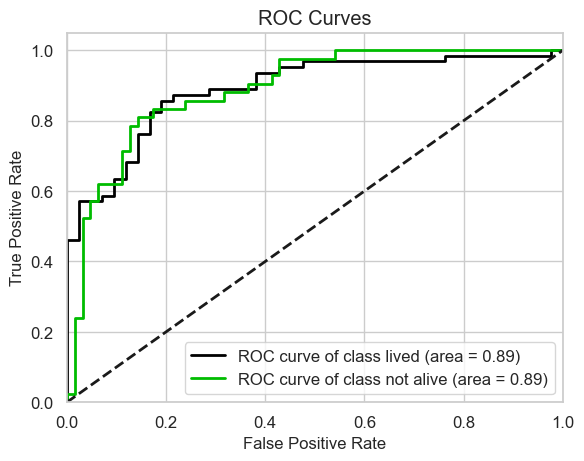

In [52]:
# Repetimos el procedimiento de puesta a punto

# Entrenar el modelo con GridSearchCV
params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

GCV = GridSearchCV(NB_model, params, scoring='roc_auc', n_jobs=-1, cv=cv)
GCV.fit(X_train, y_train)

# Mejor estimador
best_NB_model = GCV.best_estimator_
print(f"Valor óptimo de alpha: {best_NB_model.alpha}")

# Predecir y calcular probabilidades
y_pred = best_NB_model.predict(X_test)
pred_prob = best_NB_model.predict_proba(X_test)

# Función resumen resultados
Classification_Summary(y_pred, pred_prob, 3)

le = LabelEncoder()
y_test_binary = le.fit_transform(y_test)
fpr, tpr, _ = roc_curve(y_test_binary, pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

In [53]:
end_evaluation(start_time, memory_before, NB_model, X_test)

Tiempo de entrenamiento: 3.232971429824829 segundos
Uso de memoria antes del entrenamiento: 273472.0 KB
Uso de memoria después del entrenamiento: 275232.0 KB
Tamaño del modelo: 4.57763671875e-05 MB


Conclusiones modelos de Naive Bayes

--- 

Los modelos ensayados que mostraron mejor performance fueron los que utilizaron todas las variables disponibles en el dataframe. Sin embargo, esto no es adecuado ya que el tipo de datos no cumple con los supuestos necesarios para que sea correcta su aplicación. Por lo tanto, el modelo base que contempla todas las features preseleccionadas y codificadas en el dataframe de trabajo solo se expone a modo de ejemplo y para considerar los parámetros de base.

La premisa de "naive" del modelo de clasificación Naive Bayes supone la independencia condicional de las características, dadas las clases. Esta es un supuesto que en este caso es poco realista. El conocimiento de la compleja fisiopatología del sindrome estudiado establece que muchos de los parámtros clínicos y anatomopatológicos determinadas en el paciente tienen una causa común o exhiben relación causal entre ellas. Por ende, aún intentando seleccionar aquellas más "teóricamente distantes", este modelo no nos muestra una ventaja comparativa frente a otros más complejos. Por otro lado, la selección de algunas de las características basándonos en su distancia fisiopatológica nos ha dado como resultado un modelo de desempeño más pobre pero de menor tiempo de procesamiento. El tercer modelo recupera de cierta forma el desempeño del primero (en términos de accuracy y F1) por el agrupamiento de las categorías 'died' y 'euthanized', pero a expensas de una gran pérdida de información (justamente la capacidad de diferenciar el caso de muerte espontánea vs. indicación de eutanasia - ver introducción).

En los primeros dos casos el valor de alpha seleccionado por Cross Validation fue de 0.01, lo cual es conocido como Lidstone smoothing (una variante de Laplace Smoothing). En el tercero, un suavizado de 10 es más fuerte. En todo caso, el valor de alpha o smoothing permite manejar probabilidades nulas para eventos no observados y evita el sobreajuste a los datos de entrenamiento. 

Por último, la simpleza del modelo de Naive Bayes también es una ventaja clara en datasets con un gran número de registros - sin embargo, podríamos decir que al tratarse de una base pequeña (con solo 299 registros) este beneficio se desdibuja.

<h2 style="font-style: italic;">Modelo de KNN Neighbors</h2>

Comenzaremos a clasificar la variable outcome utilizando el modelo de KNN Neighbors.

In [54]:
# Realizamos una copia de trabajo 
horse_health_knn = horse_health.copy()
X = horse_health_knn.drop(['outcome'], axis=1)
y = horse_health_knn['outcome']

In [55]:
#Transformamos las categorías de tipo str a números
category_mapping = {'lived': 1, 'died': 0, 'euthanized': 2}
horse_health_knn['outcome'] = horse_health_knn['outcome'].map(category_mapping)
horse_health_knn.head()

,rectal_temp,pulse,respiratory_rate,packed_cell_volume,total_protein,outcome,mucous_membrane_bright_red,mucous_membrane_dark_cyanotic,mucous_membrane_normal_pink,mucous_membrane_pale_cyanotic,...,nasogastric_reflux,peristalsis,temp_of_extremities,peripheral_pulse,surgery_0,surgery_1,surgical_lesion_0,surgical_lesion_1,age_0,age_1
0,38.5,66.0,28.0,45.0,8.4,0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,3.0,0,1,0,1,0,1
1,39.2,88.0,20.0,50.0,85.0,2,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,3.0,1,0,0,1,0,1
2,38.3,40.0,24.0,33.0,6.7,1,0.0,0.0,0.0,0.0,...,0.0,1.0,2.0,2.0,0,1,0,1,0,1
3,39.1,164.0,84.0,48.0,7.2,0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,2.0,1,0,1,0,1,0
4,37.3,104.0,35.0,74.0,7.4,0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,3.0,0,1,0,1,0,1


In [56]:
# Separar los conjuntos de entrenamiento y testeo, estratificando por clase
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, stratify=y, random_state=1)
print('Hay', y_train.shape[0], 'datos de entrenamiento y', y_test.shape[0], 'datos de testeo')

Hay 239 datos de entrenamiento y 60 datos de testeo


In [57]:
# Estandarizamos valores numéricos 
scaler = StandardScaler()

# Features - entrenamiento/train
X_train[features_numericas] = scaler.fit_transform(X_train[features_numericas])

# Features - prueba/test
X_test[features_numericas] = scaler.transform(X_test[features_numericas])


In [58]:
X_train_std = X_train
X_test_std = X_test

In [59]:
#Vemos proporciones de clases en Set de train
y_train.value_counts(normalize=True).round(2)

outcome
lived         0.59
died          0.26
euthanized    0.15
Name: proportion, dtype: float64

In [60]:
#Vemos proporciones de clases en Set de test
y_test.value_counts(normalize=True)

outcome
lived         0.60
died          0.25
euthanized    0.15
Name: proportion, dtype: float64

Vemos que es muy similar la proporción de datos de cada clase de test al set de train, que es lo que queremos lograr.

### Definición de Hiperparámetros

- Opción A: Utilizamos CV
---

In [61]:
start_time, memory_before = start_evaluation()

In [62]:
#Creamos una funcion para identificar el mejor hiperparámetro n_neighbors utilizando CV

def scores_knn(X, y, start,stop,step):   
    
    scores_para_df = [] # Lista de diccionarios: la inicializamos vacío y fuera del for loop para ir alimentándola en cada iteración
    
    for i in range(start,stop,step):
        
        # En cada iteración, instanciamos el modelo con un hiperparámetro distinto
        model = KNeighborsClassifier(n_neighbors=i)

        # cross_val_scores nos devuelve un array de 5 resultados, 
        # uno por cada partición que hizo automáticamente CV
        kf = KFold(n_splits=10, shuffle=True, random_state=10)
        cv_scores = cross_val_score(model, X_train_std, y_train, cv=kf,scoring='accuracy')

        # Para cada valor de n_neighbours, creamos un diccionario con el valor de n_neighbours 
        # y la media y el desvío de los scores
        dict_row_score = {'score_medio':np.mean(cv_scores),
                          'score_std':np.std(cv_scores),'n_neighbours':i}

        # Guardamos cada uno en la lista de diccionarios
        scores_para_df.append(dict_row_score)
    
    # Creamos el DF a partir de la lista de resultados
    df_scores = pd.DataFrame(scores_para_df)
    
    # Incorporamos los límites inferior y superior, restando y sumando el valor del desvío estándar
    df_scores['limite_inferior'] = df_scores['score_medio'] - df_scores['score_std']
    df_scores['limite_superior'] = df_scores['score_medio'] + df_scores['score_std']
    
    # Retornamos el DF
    return df_scores

In [63]:
# Probamos de 1 a 20 vecinos
df_scores= scores_knn(X_train_std, y_train, 1, 21, 1)

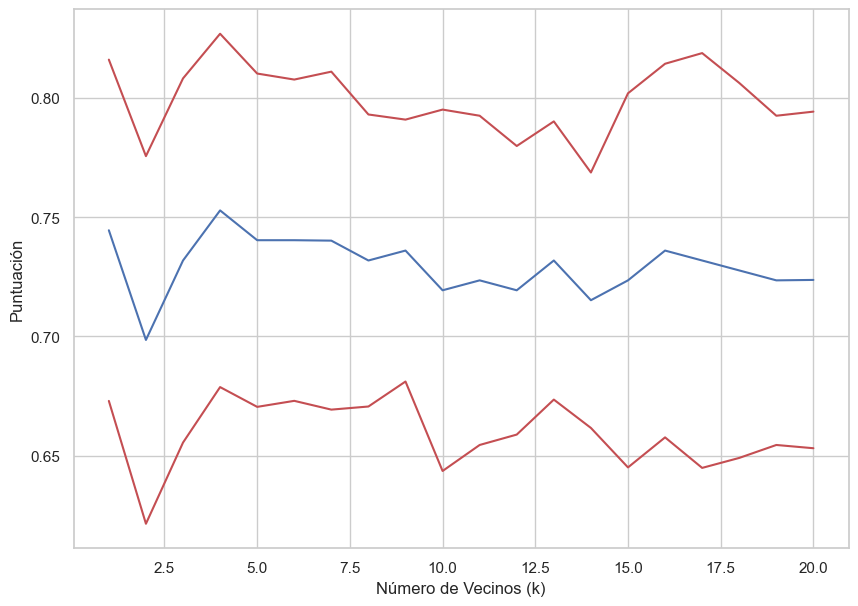

In [64]:
plt.figure(figsize=(10, 7))

# Visualizamos los resultados
plt.plot(df_scores['n_neighbours'], df_scores['limite_inferior'], color='r')
plt.plot(df_scores['n_neighbours'], df_scores['score_medio'], color='b')
plt.plot(df_scores['n_neighbours'], df_scores['limite_superior'], color='r')

# Agregar etiquetas a los ejes
plt.xlabel('Número de Vecinos (k)')
plt.ylabel('Puntuación')

# Mostrar la visualización
plt.show()

In [65]:
# Identificamos el score máximo
df_scores.loc[df_scores.score_medio == df_scores.score_medio.max()]

,score_medio,score_std,n_neighbours,limite_inferior,limite_superior
3,0.752899,0.07413,4,0.678768,0.827029


In [66]:
# Asignamos el valor del k óptimo a una variable
best_k_cv = df_scores.loc[df_scores.score_medio == df_scores.score_medio.max(),'n_neighbours'].values[0]
best_k_cv

4

In [67]:
# Elegimos el modelo óptimo que nos había indicado cross validation
model = KNeighborsClassifier(n_neighbors=best_k_cv)

# Lo ajustamos sobre datos de entrenamiento
model.fit(X_train_std, y_train)

KNeighborsClassifier(n_neighbors=4)

In [68]:
y_pred_knn_1 = model.predict(X_test_std)

Accuracy = 78.3%
F1 Score = 78.8%

 Confusion Matrix:
 [[12  0  3]
 [ 3  5  1]
 [ 6  0 30]]

Classification Report:
               precision    recall  f1-score   support

        died       0.57      0.80      0.67        15
  euthanized       1.00      0.56      0.71         9
       lived       0.88      0.83      0.86        36

    accuracy                           0.78        60
   macro avg       0.82      0.73      0.75        60
weighted avg       0.82      0.78      0.79        60



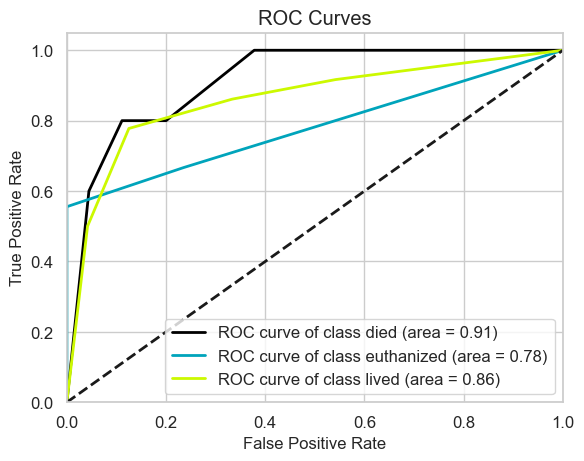

In [69]:
# Mejor estimador
best_KNN_CV_model = model
pred_prob_knn_1 = best_KNN_CV_model.predict_proba(X_test_std)

# Función resumen resultados
Classification_Summary(y_pred_knn_1, pred_prob_knn_1, 3)

In [70]:
end_evaluation(start_time, memory_before, model, X_test_std)

Tiempo de entrenamiento: 12.330511093139648 segundos
Uso de memoria antes del entrenamiento: 275416.0 KB
Uso de memoria después del entrenamiento: 280712.0 KB
Tamaño del modelo: 4.57763671875e-05 MB


- Opción B: Utilizamos GridSearch CV
---

In [71]:
#Instanciamos el modelo
knn = KNeighborsClassifier()

In [72]:
# Iniciar temporizador
start_time = time.time()

In [73]:
#Definimos la grilla de parámetros para recorrer con valores de 1 a 20
k_range = list(range(1, 21))
param_grid = dict(n_neighbors=k_range)
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]}


In [74]:
#Definimos la cantidad de folds 
folds=StratifiedKFold(n_splits=10, random_state=19, shuffle=True)

In [75]:
#Definimos el método de búsqueda 
grid = GridSearchCV(knn, param_grid, cv=folds, scoring='accuracy')

In [76]:
#Entrenamos el modelo
grid.fit(X_train_std, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=19, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20]},
             scoring='accuracy')

In [77]:
#Evaluamos el modelo
pd.DataFrame(grid.cv_results_).head(3) # Muestra un df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010750,0.009107,0.023869,0.032022,1,{'n_neighbors': 1},0.708333,0.750,0.666667,0.833333,0.833333,0.875,0.875,0.708333,0.666667,0.739130,0.765580,0.077583,1
1,0.007007,0.008206,0.014069,0.006835,2,{'n_neighbors': 2},0.625000,0.750,0.583333,0.791667,0.833333,0.875,0.750,0.708333,0.708333,0.652174,0.727717,0.087055,20
2,0.011595,0.007628,0.026076,0.017018,3,{'n_neighbors': 3},0.583333,0.875,0.625000,0.750000,0.791667,1.000,0.875,0.708333,0.666667,0.695652,0.757065,0.122484,2


In [78]:
print(f"accuracy :",grid.best_score_.round(2)) #señala el accuracy del mejor modelo con los valores de train
print(f"n° of neighbors :",grid.best_params_["n_neighbors"]) #Informa el número óptimo de vecinos.

accuracy : 0.77
n° of neighbors : 1


In [79]:
y_pred_grid = grid.predict(X_test_std)

Accuracy = 80.0%
F1 Score = 79.2%

 Confusion Matrix:
 [[12  0  3]
 [ 0  4  5]
 [ 2  2 32]]

Classification Report:
               precision    recall  f1-score   support

        died       0.86      0.80      0.83        15
  euthanized       0.67      0.44      0.53         9
       lived       0.80      0.89      0.84        36

    accuracy                           0.80        60
   macro avg       0.77      0.71      0.73        60
weighted avg       0.79      0.80      0.79        60



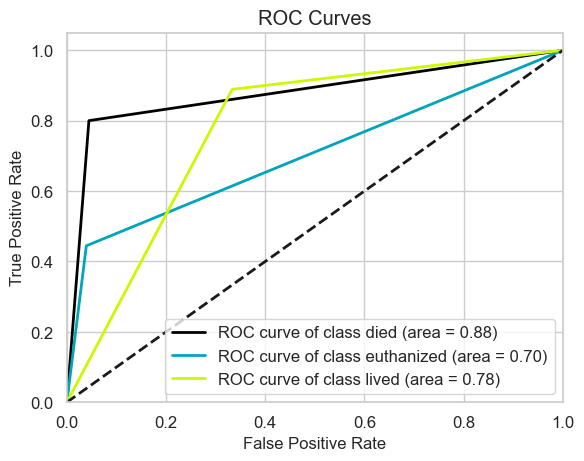

In [80]:
# Mejor estimador
best_KNN_CV_model = grid.best_estimator_
pred_prob_grid = best_KNN_CV_model.predict_proba(X_test_std)

# Función resumen resultados
Classification_Summary(y_pred_grid, pred_prob_grid, 3)

In [81]:
end_evaluation(start_time, memory_before, knn, X_test_std)

Tiempo de entrenamiento: 6.464453458786011 segundos
Uso de memoria antes del entrenamiento: 275416.0 KB
Uso de memoria después del entrenamiento: 282628.0 KB
Tamaño del modelo: 4.57763671875e-05 MB


Como resumen, tenemos que  con CV obtenemos un mejor accuracy del modelo (80%) en relación al 78% de accuracy utlizando un k=4 evaluado por el método de GS. Además, la matriz de confusión se encuentra mejor distribuída en este primer caso y obtenemos valores de AUC mayores.

El modelo muestra el mejor rendimiento en la clasificación de caballos que sobrevivieron ('lived'), con altas métricas de precisión, sensibilidad y puntuación F1. Esto sugiere que el modelo es efectivo para identificar correctamente los casos en los que los caballos sobreviven. Sin embargo, el rendimiento es menos satisfactorio en la clasificación de caballos que murieron ('died') y aun menos satifactorio con los que fueron sacrificados ('euthanized'), donde la precisión y el recall son bajos. Estos resultados podrían indicar que el modelo tiene dificultades para distinguir entre los diferentes resultados de salud de los caballos, lo que podría ser crucial en la toma de decisiones clínicas. Sobretodo teniendo en cuenta los valores de rendimiento en cuanto a los sacrificados.
Es necesario tener en cuenta los datos que estamos analizando. Es posible que con una mayor muestra el rendimiento mejore, es posible que haya mucho sesgo 

- Opción C: Utilizamos Gridsearch CV con más parametros
---

Para continuar con la búsqueda del mejor modelo, probamos realizar otro análisis de GridSearch evaluando otros parámetros para ver si mejoraba el rendimiento del modelo. Consideramos los parámetros "n_neighbors","weights","metric"

In [82]:
start_time, memory_before = start_evaluation()

In [83]:
# Modelo KNN
knn = KNeighborsClassifier()

# Definimos los parámetros para la búsqueda
parameters = {'n_neighbors': range(1, 30), 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}

# GridSearch sobre los parametros
grid_search = GridSearchCV(knn, parameters, cv=folds, scoring='accuracy')

# Ajustar la búsqueda en cuadrícula a los datos de entrenamiento
grid_search.fit(X_train_std, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=19, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': range(1, 30),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [84]:
# Imprimir los mejores parámetros y el mejor puntaje
print('Mejores parametros:', grid_search.best_params_)

# Usar el mejor modelo para hacer predicciones
y_pred_grid_2 = grid_search.predict(X_test_std)

# Evaluar el accuracy del modelo en test
print('Test accuracy:', accuracy_score(y_test, y_pred_grid_2).round(2))

Mejores parametros: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Test accuracy: 0.83


Accuracy = 83.3%
F1 Score = 83.0%

 Confusion Matrix:
 [[13  0  2]
 [ 1  5  3]
 [ 4  0 32]]

Classification Report:
               precision    recall  f1-score   support

        died       0.72      0.87      0.79        15
  euthanized       1.00      0.56      0.71         9
       lived       0.86      0.89      0.88        36

    accuracy                           0.83        60
   macro avg       0.86      0.77      0.79        60
weighted avg       0.85      0.83      0.83        60



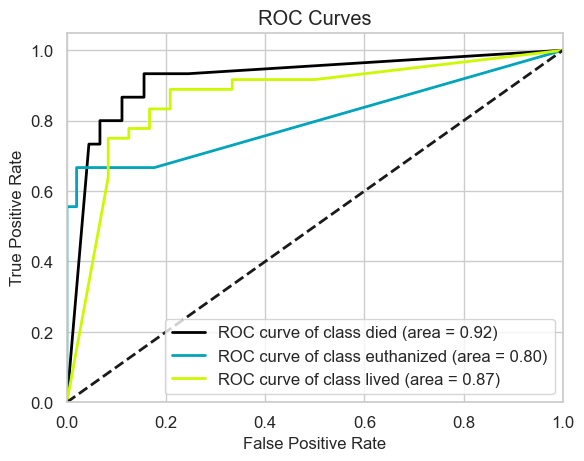

In [85]:
# Mejor estimador
best_KNN_grid_model = grid_search.best_estimator_
pred_prob = best_KNN_grid_model.predict_proba(X_test_std)

# Función resumen resultados
Classification_Summary(y_pred_grid_2, pred_prob, 3)

In [86]:
end_evaluation(start_time, memory_before, knn, X_test_std)

Tiempo de entrenamiento: 26.920745849609375 segundos
Uso de memoria antes del entrenamiento: 282628.0 KB
Uso de memoria después del entrenamiento: 285548.0 KB
Tamaño del modelo: 4.57763671875e-05 MB


Conclusiones

--- 

Al observar los resultados a simple vista se puede observar que modificando los parámetros por default obtenemos un mejor rendimiento. Esto se puede ver en el gráfico de curvas ROC en donde cada vez son mas parecidas a la curva por excelencia, y además tenemos valores de AUC mucho mayores, casi aproximandose al valor máximo=1

Si bien el Accuracy no es la mejor métrica para este Dataset debido al desbalanceo de los datos en las 3 clases, tenemos un accuracy de 83% vs un accuracy de 80% en el modelo anterior, lo que implica que mejoramos aunque sea en un 3% la cantidad de etiquetas correctamente predichas sobre el total

Finalmente, si analizamos la métrica F1 (la cual es la media armónica entre Recall y Precisión, por lo cual ambos valores deben ser altos para tener un alto F1-Score), tenemos que también mejoro sustancialmente en las 3 categorias. 

En la categoría "lived" tenemos un valor alto de precisión, lo que nos asegura los verdaderos positivos. En ambos modelos tenemos valores altos, sin embargo con este último ajuste pasamos de 80% a 86% de precisión 

Tanto para las categorías "lived" como "died" tenemos un valor de recall alto, lo cual es muy útil ya que no deseamos mantener falsos negativos. Sin embargo, no tenemos una tan buena performance en los casos de "eut" ya que se observa un valor de recall de 22%. Esto implica la presencia de falsos negativos

<h2 style="font-style: italic;">Modelo de Regresión Logística</h2>

#### Correlación entre features y target:
---

In [87]:
#Realizamos una copia del dataset original 
horse_health_lr = horse_health.copy()

In [88]:
horse_health_lr['outcome'].value_counts()

outcome
lived         178
died           77
euthanized     44
Name: count, dtype: int64

In [89]:
horse_health_lr.head(5)

,rectal_temp,pulse,respiratory_rate,packed_cell_volume,total_protein,outcome,mucous_membrane_bright_red,mucous_membrane_dark_cyanotic,mucous_membrane_normal_pink,mucous_membrane_pale_cyanotic,...,nasogastric_reflux,peristalsis,temp_of_extremities,peripheral_pulse,surgery_0,surgery_1,surgical_lesion_0,surgical_lesion_1,age_0,age_1
0,38.5,66.0,28.0,45.0,8.4,died,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,3.0,0,1,0,1,0,1
1,39.2,88.0,20.0,50.0,85.0,euthanized,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,3.0,1,0,0,1,0,1
2,38.3,40.0,24.0,33.0,6.7,lived,0.0,0.0,0.0,0.0,...,0.0,1.0,2.0,2.0,0,1,0,1,0,1
3,39.1,164.0,84.0,48.0,7.2,died,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,2.0,1,0,1,0,1,0
4,37.3,104.0,35.0,74.0,7.4,died,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,3.0,0,1,0,1,0,1


In [90]:
horse_health_lr_corr = horse_health_lr.copy()

In [91]:
#Recategorizamos las clases para simplificar el análisis y la regresión
category_mapping = {'lived': 1, 'died': 0, 'euthanized': 2}

horse_health_lr_corr['outcome'].replace(category_mapping, inplace=True)

In [92]:
#Revisamos que las clases estén etiquetadas correctamente.
horse_health_lr_corr['outcome'].value_counts()

outcome
1    178
0     77
2     44
Name: count, dtype: int64

In [93]:
horse_health_lr['outcome'].value_counts()

outcome
lived         178
died           77
euthanized     44
Name: count, dtype: int64

In [94]:
horse_health_lr_corr.head()

,rectal_temp,pulse,respiratory_rate,packed_cell_volume,total_protein,outcome,mucous_membrane_bright_red,mucous_membrane_dark_cyanotic,mucous_membrane_normal_pink,mucous_membrane_pale_cyanotic,...,nasogastric_reflux,peristalsis,temp_of_extremities,peripheral_pulse,surgery_0,surgery_1,surgical_lesion_0,surgical_lesion_1,age_0,age_1
0,38.5,66.0,28.0,45.0,8.4,0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,3.0,0,1,0,1,0,1
1,39.2,88.0,20.0,50.0,85.0,2,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,3.0,1,0,0,1,0,1
2,38.3,40.0,24.0,33.0,6.7,1,0.0,0.0,0.0,0.0,...,0.0,1.0,2.0,2.0,0,1,0,1,0,1
3,39.1,164.0,84.0,48.0,7.2,0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,2.0,1,0,1,0,1,0
4,37.3,104.0,35.0,74.0,7.4,0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,3.0,0,1,0,1,0,1


<Axes: title={'center': 'Matriz de correlación'}>

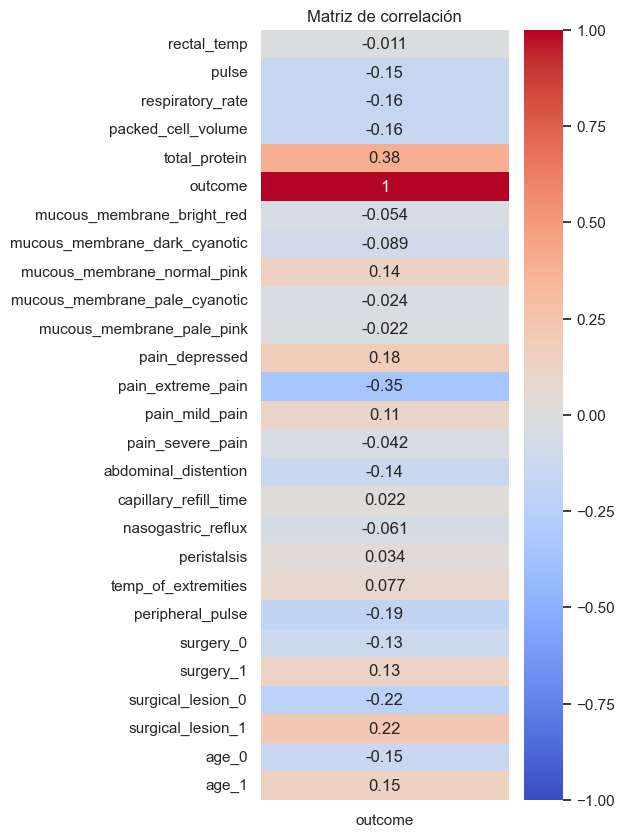

In [95]:
filtro_lesion = [col for col in horse_health_lr_corr.columns if not col.startswith(('lesion_1', 'lesion_2', 'lesion_3'))]

# Genero la matriz de correlación pero sólo con respecto a la columna outcome, nuestro target.
plt.figure(figsize=(4,10))
plt.title('Matriz de correlación')
sns.heatmap(horse_health_lr_corr[filtro_lesion].corr(method='spearman')[['outcome']], annot=True, cmap='coolwarm', vmin=-1, vmax=1)

#### Modelo de Regresión Logistica con features con mayor correlación con el Outcome:
---

Tomamos todas las features con valores de correlacion en los intervalos [-1 , -0.15] y [0.15 , 1]

Las features tomadas fueron:
    <ul>
     <li>pulso</li>
     <li>volumen celular</li>
     <li>proteina total</li>
     <li>dolor: deprimido</li>
     <li>dolor: extremo</li>
     <li>pulso periférico</li>
     <li>lesiones de resolución quirúrgica</li>
     <li>edad</li>
    </ul>

In [96]:
#Tomamos las columnas mencionadas con mejor correlación del dataset (best features).
df_lr_bf= horse_health_lr[["pulse","packed_cell_volume","total_protein","pain_depressed","pain_extreme_pain","peripheral_pulse","surgical_lesion_0","surgical_lesion_1","age_0","outcome"]].copy()
df_lr_bf.head()

,pulse,packed_cell_volume,total_protein,pain_depressed,pain_extreme_pain,peripheral_pulse,surgical_lesion_0,surgical_lesion_1,age_0,outcome
0,66.0,45.0,8.4,0.0,1.0,3.0,0,1,0,died
1,88.0,50.0,85.0,0.0,0.0,3.0,0,1,0,euthanized
2,40.0,33.0,6.7,0.0,0.0,2.0,0,1,0,lived
3,164.0,48.0,7.2,1.0,0.0,2.0,1,0,1,died
4,104.0,74.0,7.4,0.0,1.0,3.0,0,1,0,died


In [97]:
df_lr_bf.columns

Index(['pulse', 'packed_cell_volume', 'total_protein', 'pain_depressed',
       'pain_extreme_pain', 'peripheral_pulse', 'surgical_lesion_0',
       'surgical_lesion_1', 'age_0', 'outcome'],
      dtype='object')

- Definimos X e y, generamos subconjuntos de entrenamiento y prueba

In [98]:
X_lr_bf = df_lr_bf.drop('outcome', axis=1)
y_lr_bf = df_lr_bf['outcome']

In [99]:
y_lr_bf.value_counts()

outcome
lived         178
died           77
euthanized     44
Name: count, dtype: int64

In [100]:
# Divide los datos en conjuntos de entrenamiento y prueba para las features elegidas
X_train_lr_bf, X_test_lr_bf, y_train_lr_bf, y_test_lr_bf = train_test_split(X_lr_bf, y_lr_bf, test_size=0.2,stratify=y, random_state=1)

In [101]:
#Vemos las dimensiones de los conjuntos resultantes

print(X_train_lr_bf.shape)
print(X_test_lr_bf.shape)
print(y_train_lr_bf.shape)
print(y_test_lr_bf.shape)

(239, 9)
(60, 9)
(239,)
(60,)


- Escalamos los datos, estandarizamos los valores y definimos el Modelo a utilizar con un número de iteraciones.

In [102]:
scaler = StandardScaler()

In [103]:
X_train_std_lr_bf = scaler.fit_transform(X_train_lr_bf)
X_test_std_lr_bf = scaler.transform(X_test_lr_bf)

In [104]:
# Definir el modelo con un número mayor de iteraciones
lr_bf = LogisticRegression(max_iter=1000)

- Generamos los parámetros de la inversa de la fuerza de regularización, y los folds para aplicar en Grid Search.

In [105]:
start_time, memory_before = start_evaluation()

In [106]:
#Parámetros de la inversa de la fuerza de regularización para aplicar en el Grid Search
params = {'C': [0.001, 0.01, 0.1, 1, 10,100]}

In [107]:
folds = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

- Creamos y ajustamos el modelo con Gridsearch.

In [108]:
# Crear el objeto GridSearchCV
GCV_lr_bf = GridSearchCV(lr_bf, params, cv=folds, scoring='accuracy')

In [109]:
# Ajustar el modelo con GridSearchCV
GCV_lr_bf.fit(X_train_std_lr_bf, y_train_lr_bf)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='accuracy')

In [110]:
#Valores predichos
y_pred_lr_bf=GCV_lr_bf.predict(X_test_std_lr_bf)

- Mejor parámetro es  'C'= 1

In [111]:
# Vemos los mejores parámetros encontrados
print("Mejores parámetros: ", GCV_lr_bf.best_params_)
print("Mejor puntuación: ", GCV_lr_bf.best_score_)

Mejores parámetros:  {'C': 100}
Mejor puntuación:  0.7221618357487923


In [112]:
#Usamos el mejor modelo encontrado directamente
best_model_lr_bf = GCV_lr_bf.best_estimator_
best_model_lr_bf

LogisticRegression(C=100, max_iter=1000)

In [113]:
#Probabilidades estimadas
pred_prob_lr_bf = GCV_lr_bf.predict_proba(X_test_std_lr_bf)

Accuracy = 76.7%
F1 Score = 76.2%

 Confusion Matrix:
 [[14  0  1]
 [ 1  4  4]
 [ 5  3 28]]



Classification Report:
               precision    recall  f1-score   support

        died       0.70      0.93      0.80        15
  euthanized       0.57      0.44      0.50         9
       lived       0.85      0.78      0.81        36

    accuracy                           0.77        60
   macro avg       0.71      0.72      0.70        60
weighted avg       0.77      0.77      0.76        60



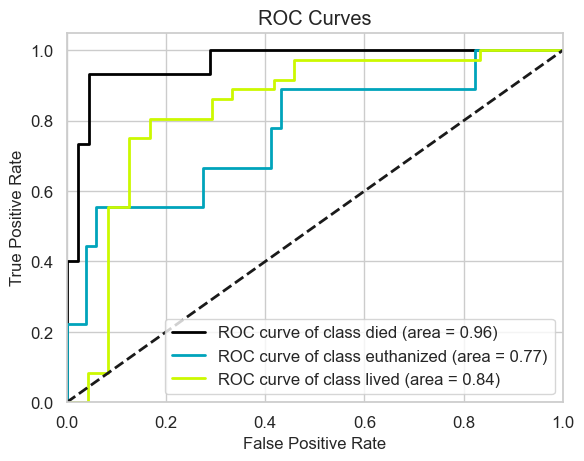

In [114]:
# Función resumen resultados
Classification_Summary(y_pred_lr_bf, pred_prob_lr_bf, 3)

In [115]:
end_evaluation(start_time, memory_before, lr_bf, X_test_std_lr_bf)

Tiempo de entrenamiento: 4.447969198226929 segundos
Uso de memoria antes del entrenamiento: 290428.0 KB
Uso de memoria después del entrenamiento: 292588.0 KB
Tamaño del modelo: 4.57763671875e-05 MB


- Conclusión modelo Regresión con seleccion de Features:
---
Nuevamente observamos que el modelo es efectivo para identificar con mayor precisión los casos en los que los caballos sobreviven ('lived') ya que obtenemos altas métricas de precisión y puntuación F1, siendo más fuerte la métrica recall (sensibilidad) para la predicción de caballos que murieron.
De misma forma se repite la baja capacidad del modelo para predecir aquellos caballos que serán eutanasiados ('euthanized') guiándonos por las 3 mismas métricas, lo que deriva en una dificultad a la hora de tomar decisiones clínicas.
Es necesario tener en cuenta los datos que estamos analizando. Es posible que con una mayor muestra el rendimiento mejore, asimismo es posible que haya mucho sesgo.

#### Modelo de Regresión Logística con todas las features disponibles en el Dataset:
---

In [116]:
#Armamos los conjuntos X e y
X_lr_t = horse_health_lr.drop(['outcome'], axis=1)
y_lr_t = horse_health_lr['outcome']

In [117]:
#Dividimos nuestras features y target en entrenamiento y testeo
X_train_lr_t, X_test_lr_t, y_train_lr_t, y_test_lr_t = train_test_split(X_lr_t, y_lr_t, test_size=0.2, stratify=y, random_state=1)

In [118]:
#Vemos las dimensiones de los conjuntos resultantes
print(X_train_lr_t.shape)
print(X_test_lr_t.shape)
print(y_train_lr_t.shape)
print(y_test_lr_t.shape)

(239, 92)
(60, 92)
(239,)
(60,)


In [119]:
# Escalar los datos
scaler = StandardScaler()

In [120]:
#Conjuntos de entrenamiento y testeo escalados
X_train_lr_t[features_numericas]= scaler.fit_transform(X_train_lr_t[features_numericas])
X_test_lr_t[features_numericas] = scaler.transform(X_test_lr_t[features_numericas])

In [121]:
start_time, memory_before = start_evaluation()

In [122]:
# Definir el modelo con un número mayor de iteraciones
lr_t = LogisticRegression(max_iter=1000)

In [123]:
#Parámetros de la inversa de la fuerza de regularización para aplicar en el Grid Search
params = {'C': [0.001, 0.01, 0.1, 1, 10,100]}

In [124]:
folds = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [125]:
# Crear el objeto GridSearchCV
GCV_lr_t = GridSearchCV(lr_t, params, cv=folds, scoring='accuracy')

In [126]:
# Ajustar el modelo con GridSearchCV
GCV_lr_t.fit(X_train_lr_t, y_train_lr_t)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='accuracy')

In [127]:
#Valores predichos
y_pred_lr_t=GCV_lr_t.predict(X_test_lr_t)

In [128]:
# Ver los mejores parámetros encontrados
print("Mejores parámetros: ", GCV_lr_t.best_params_)
print("Mejor puntuación: ", GCV_lr_t.best_score_)

Mejores parámetros:  {'C': 1}
Mejor puntuación:  0.7791062801932368


In [129]:
# Puedes usar el mejor modelo encontrado directamente
best_model_lr_t = GCV_lr_t.best_estimator_
best_model_lr_t

LogisticRegression(C=1, max_iter=1000)

In [130]:
#Probabilidades estimadas
pred_prob_lr_t = GCV_lr_t.predict_proba(X_test_lr_t)

Accuracy = 83.3%
F1 Score = 83.1%

 Confusion Matrix:
 [[14  1  0]
 [ 1  5  3]
 [ 4  1 31]]

Classification Report:
               precision    recall  f1-score   support

        died       0.74      0.93      0.82        15
  euthanized       0.71      0.56      0.63         9
       lived       0.91      0.86      0.89        36

    accuracy                           0.83        60
   macro avg       0.79      0.78      0.78        60
weighted avg       0.84      0.83      0.83        60



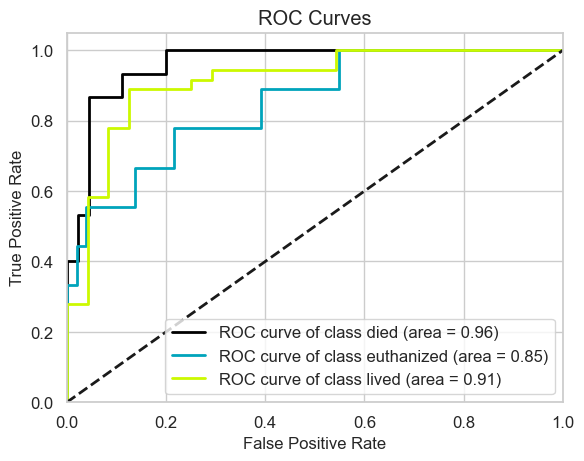

In [131]:
# Función resumen resultados
Classification_Summary(y_pred_lr_t, pred_prob_lr_t, 3)

In [132]:
end_evaluation(start_time, memory_before, lr_t, X_test_lr_t)

Tiempo de entrenamiento: 18.89586353302002 segundos
Uso de memoria antes del entrenamiento: 292680.0 KB
Uso de memoria después del entrenamiento: 294772.0 KB
Tamaño del modelo: 4.57763671875e-05 MB


##### Comparación de Modelos - Regresión Logística:
---


Notamos que al utilizar el 100% de las features mejora aun más la capacidad del Modelo para predecir el destino de los caballos en las 3 categorías que tenemos, si viven, mueren o serán eutanasiados.
Esto se puede ver en el gráfico de curvas ROC en donde cada vez son mas parecidas a la curva ideal, y además tenemos valores de AUC mucho mayores.

Si bien, como se mencionó en otras etapas del informe, Accuracy no es la mejor métrica para este dataset debido al desbalanceo de los datos en las tres clases objetivo, podemos enfocarnos en la mejora de la puntuación F1 global de 76.5% a 78% (+2%) y de su mejora e las 3 categorías por separado, ya que es una métrica clave en entornos médicos ya que esta facilita la ponderación efectiva para la correcta identificación de la condición de salud del caballo (sensibilidad) y la minimización de falsas alarmas para evitar tomar decisiones incorrectas respecto a su destino (precisión).

Luego, observamos que la precisión mejora con respecto al modelo KNN, lo cual es util ya qe mejora el nivel de precisión en el acierto de estas categorías que son las más complejas de detectar en nuestros modelos.

Se mantienen las proporciones en las que para las categorías "lived" como "died" tenemos un valor de recall alto, lo cual es muy útil ya que no deseamos mantener falsos negativos. Sin embargo, no tenemos una tan buena performance en los casos autanasiados ya que se observa un valor de recall de 44%. Esto implica la presencia de falsos negativos, pero en mucha menor medida que en el modelo KNN y NB, por lo que es la mejor sensibilidad a la que podemos llegar con los datos disponibles.

<table style="width:100%">
  <tr>
    <th style="background:#F54DC2; color:white; font:oblique bold 120% cursive;">Magnitud</th>
    <th style="background:#F5D94D; color:white; font:oblique bold 120% cursive;" colspan="4">Naive Bayes</th>
    <th style="background:#F54DC2; color:white; font:oblique bold 120% cursive;" colspan="3">KNN Neighbors</th>
    <th style="background:#F5D94D; color:white; font:oblique bold 120% cursive;" colspan="2">Regresión Logística</th>
  </tr>
  <tr>
    <th style="background:#F9E2F2; font:oblique bold 100% cursive;" rowspan="4">Recall</th>
    <th style="background:#FDFEFE; font:oblique bold 100% cursive;">Total Features</th>
    <th style="background:#FDEFA9; font:oblique bold 100% cursive;">Stratified Shuffle Splits</th>
    <th style="background:#FDFEFE; font:oblique bold 100% cursive;">Features menos relacionadas</th>
    <th style="background:#FDEFA9; font:oblique bold 100% cursive;">Uniendo muertos y eutanasiados</th>
    <th style="background:#FDFEFE; font:oblique bold 100% cursive;">Cross Validation</th>
    <th style="background:#F9E2F2; font:oblique bold 100% cursive;">Grid Search</th>
    <th style="background:#FDFEFE; font:oblique bold 100% cursive;">Grid Search más parámetros</th>
    <th style="background:#FDEFA9; font:oblique bold 100% cursive;">Features mejor corr.</th>
    <th style="background:#FDFEFE; font:oblique bold 100% cursive;">Total Features</th>
  </tr>
  <tr>
    <td style="background:#FDFEFE;">V: 0.90</td>
    <td style="background:#FDEFA9;">V: 0.90</td>
    <td style="background:#FDFEFE;">V: 0.83</td>
    <td style="background:#FDEFA9;">V: 0.81</td>
    <td style="background:#FDFEFE;">V: 0.83</td>
    <td style="background:#F9E2F2;">V: 0.89</td>
    <td style="background:#FDFEFE;">V: 0.89</td>
    <td style="background:#FDEFA9;">V: 0.78</td>
    <td style="background:#FDFEFE;">V: 0.86</td>
  </tr>
  <tr>
    <td style="background:#FDFEFE;">M: 0.74</td>
    <td style="background:#FDEFA9;">M: 0.74</td>
    <td style="background:#FDFEFE;">M: 0.74</td>
    <td style="background:#FDEFA9;">NV: 0.83</td>
    <td style="background:#FDFEFE;">M: 0.80</td>
    <td style="background:#F9E2F2;">M: 0.80</td>
    <td style="background:#FDFEFE;">M: 0.87</td>
    <td style="background:#FDEFA9;">M: 0.93</td>
    <td style="background:#FDFEFE;">M: 0.93</td>
  </tr>
  <tr>
    <td style="background:#FDFEFE;">E: 0.20</td>
    <td style="background:#FDEFA9;">E: 0.20</td>
    <td style="background:#FDFEFE;">E: 0.20</td>
    <td style="background:#FDEFA9;"> </td>
    <td style="background:#FDFEFE;">E: 0.56</td>
    <td style="background:#F9E2F2;">E: 0.44</td>
    <td style="background:#FDFEFE;">E: 0.56</td>
    <td style="background:#FDEFA9;">E: 0.44</td>
    <td style="background:#FDFEFE;">E: 0.56</td>
  </tr>
  <tr>
    <th style="background:#F9E2F2; font:oblique bold 100% cursive;">F1 Score</th>
    <td style="background:#FDFEFE;">74.2%</td>
    <td style="background:#FDEFA9;">74.2%</td>
    <td style="background:#FDFEFE;">70.6%</td>
    <td style="background:#FDEFA9;">82%</td>
    <td style="background:#FDFEFE;">78.8%</td>
    <td style="background:#F9E2F2;">79.2%</td>
    <td style="background:#FDFEFE;">83%</td>
    <td style="background:#FDEFA9;">76.2%</td>
    <td style="background:#FDFEFE;">83.1%</td>
  </tr>
  <tr>
    <th style="background:#F9E2F2; font:oblique bold 100% cursive;">Accuracy</th>
    <td style="background:#FDFEFE;">76.2%</td>
    <td style="background:#FDEFA9;">76.2%</td>
    <td style="background:#FDFEFE;">71.4%</td>
    <td style="background:#FDEFA9;">81.9%</td>
    <td style="background:#FDFEFE;">78.3%</td>
    <td style="background:#F9E2F2;">80%</td>
    <td style="background:#FDFEFE;">83.3%</td>
    <td style="background:#FDEFA9;">76.7%</td>
    <td style="background:#FDFEFE;">83.3%</td>
  </tr>
  <tr>
    <th style="background:#F9E2F2; font:oblique bold 100% cursive; vertical-align: top;" rowspan="3" valign="top">AUC</th>
    <td style="background:#FDFEFE;">V: 0.91</td>
    <td style="background:#FDEFA9;">V: 0.91</td>
    <td style="background:#FDFEFE;">V: 0.89</td>
    <td style="background:#FDEFA9;">V: 0.89</td>
    <td style="background:#FDFEFE;">V: 0.86</td>
    <td style="background:#F9E2F2;">V: 0.78</td>
    <td style="background:#FDFEFE;">V: 0.87</td>
    <td style="background:#FDEFA9;">V: 0.84</td>
    <td style="background:#FDFEFE;">V: 0.91</td>
  </tr>
  <tr>
    <td style="background:#FDFEFE;">M: 0.86</td>
    <td style="background:#FDEFA9;">M: 0.86</td>
    <td style="background:#FDFEFE;">M: 0.88</td>
    <td style="background:#FDEFA9;">NV: 0.89</td>
    <td style="background:#FDFEFE;">M: 0.91</td>
    <td style="background:#F9E2F2;">M: 0.88</td>
    <td style="background:#FDFEFE;">M: 0.92</td>
    <td style="background:#FDEFA9;">M: 0.96</td>
    <td style="background:#FDFEFE;">M: 0.96</td>
  </tr>
  <tr>
    <td style="background:#FDFEFE;">E: 0.78</td>
    <td style="background:#FDEFA9;">E: 0.78</td>
    <td style="background:#FDFEFE;">E: 0.83</td>
    <td style="background:#FDEFA9;"> </td>
    <td style="background:#FDFEFE;">E: 0.78</td>
    <td style="background:#F9E2F2;">E: 0.70</td>
    <td style="background:#FDFEFE;">E: 0.80</td>
    <td style="background:#FDEFA9;">E: 0.77</td>
    <td style="background:#FDFEFE;">E: 0.85</td>
  </tr>
</table>

<h2 style="font-style: italic;">Conclusión general del trabajo</h2>

El modelo elegido es RL-2 (regresión logística considerando todas las variables predictoras disponibles luego de la limpieza). Cabe agregar que el modelo elegido modelo igualó o superó a los demás en todos los parámetros de éxito en las tres categorías evaluadas, pero como la predicción de la clases "Lived" fue buena en todos los casos, y teniendo en cuenta el objetivo que nos planteamos, haremos foco en las clases "Died" y "Euthanized". El segundo modelo a considerar es el KNN con gridsearch con más parámetros (KNN-3), que demostró un desempeño similar.

Este es un resumen de las métricas obtenidas para estas clases:
- Precisión para "Died" y "Euthanized" es de 74% y 71%, respectivamente. Esto significa que, de todas las predicciones positivas que hace el modelo para cada clase, el 74% de las predicciones para "Died" y el 71% de las predicciones para "Euthanized" son correctas.
- Recall/Sensitivity para "Died" y "Euthanized" es de 93% y 56%, respectivamente. Esto significa que el 93% de los animales que realmente morirán fueron identificados correctamente por el modelo, mientras que el 56% de los animales que realmente serán eutanasiados fueron identificados correctamente.
- F1-score para "Died" y "Euthanized" es de 0.82 y 0.63, respectivamente. Esta medida es interesante por el desequilibrio entre clases y refleja el desafío de identificar correctamente los animales que serán eutanasiados.
- La AUC es de 0.96 y 0.85, lo que sugiere un buen rendimiento del modelo en la distinción entre las clases y un buen rendimiento del modelo en general.

Dado que la prioridad del negocio es predecir (categorizar) correctamente los animales que morirán o serán eutanasiados, es preferible minimizar los falsos negativos (casos en los que el modelo predice incorrectamente que un animal no morirá o será eutanasiado cuando en realidad sí lo será). Por ende, es importante tener en cuenta el recall como una métrica clave. Dado que queremos minimizar los falsos negativos, es esencial maximizar el recall para las clases relevantes (en este caso, "Died" y "Euthanized"). F1 también resulta una métrica clave, porque nos habla del balance entre precisión y recall, lo que significa que es capaz de predecir correctamente tanto los casos positivos como los negativos de esta clase. Como se mencionó antes, este modelo exhibió el mejor desempeño en este ámbito.

Debemos tener en cuenta que, si bien este modelo también presenta algunos falsos positivos (lo cual es esperable por el natural trade-off entre sensibilidad y especificidad), su capacidad para capturar la mayoría de los casos positivos (al menos en la clase "Died", y relativamente en "Euthanized") es fundamental para el objetivo de predecir correctamente los animales asegurados que serán más problemáticos para el negocio de la aseguradora.

En este punto es muy importante aclarar que el desafío de los modelos fue detectar adecuadamente aquellos animales con outcome = "Euthanized", lo cual también inclinó la balanza en la decisión final. Es posible que sea necesario evaluar un mayor número de casos de cólico con este desenlace, o incorporar otras variables como el análisis del texto de reportes veterinarios, para poder obtener más información. Se exploraron algunas opciones dentro de la separación train-test-split que mejoraron los resultados, mientras que otras, como el oversampling a través de SMOTE (Syntetic Minority Over-sampling Technique), sorpresivamente no lo hicieron.

Finalmente, mencionamos que se deben tener en cuenta otras variables que pueden influir como el costo computacional, la escalabilidad, la complejidad del modelo, etc., que podrían influir sobre una decisión final de factibilidad y viabilidad para el negocio.

<h2 style="font-style: italic;">Bonus Track: Árbol de Decisión</h2>

##### Árbol de decisión tomando todas las variables predictoras
---

In [133]:
#Realizamos una copia del dataset original 
horse_health_tree = horse_health.copy()

In [134]:
#Armamos los conjuntos X e y
X_tree = horse_health_tree.drop(['outcome'], axis=1)
y_tree = horse_health_tree['outcome']

In [135]:
#Dividimos nuestras features y target en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X_tree, y_tree, test_size=0.35, stratify=y, random_state=1)

In [136]:
# Escalar los datos
scaler = StandardScaler()

# Features - entrenamiento/train
X_train[features_numericas] = scaler.fit_transform(X_train[features_numericas])

# Features - prueba/test
X_test[features_numericas] = scaler.transform(X_test[features_numericas])

In [137]:
start_time, memory_before = start_evaluation()

Mejores parámetros encontrados:
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy = 68.60000000000001%
F1 Score = 67.80000000000001%

 Confusion Matrix:
 [[14  2 11]
 [ 3  6  6]
 [ 6  5 52]]

Classification Report:
               precision    recall  f1-score   support

        died       0.61      0.52      0.56        27
  euthanized       0.46      0.40      0.43        15
       lived       0.75      0.83      0.79        63

    accuracy                           0.69       105
   macro avg       0.61      0.58      0.59       105
weighted avg       0.67      0.69      0.68       105



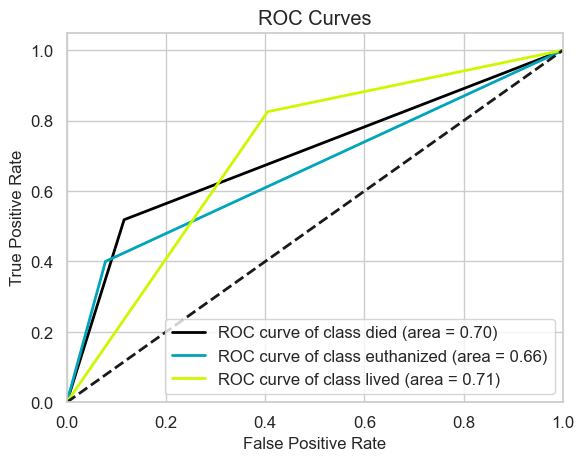

In [138]:
from sklearn.tree import DecisionTreeClassifier

# Definir los parámetros de búsqueda para GridSearchCV
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Crear una instancia del modelo de árbol de decisión
tree_model = DecisionTreeClassifier(random_state=1)

# Configurar GridSearchCV con el modelo y los parámetros de búsqueda
tree_GCV = GridSearchCV(tree_model, params, scoring='roc_auc', n_jobs=-1, cv=cv)

# Ajustar GridSearchCV a los datos de entrenamiento
tree_GCV.fit(X_train, y_train)

# Obtener el mejor modelo y sus parámetros óptimos
best_tree_model = tree_GCV.best_estimator_
print("Mejores parámetros encontrados:")
print(tree_GCV.best_params_)

# Predecir y calcular probabilidades
y_pred_tree = best_tree_model.predict(X_test)
pred_prob_tree = best_tree_model.predict_proba(X_test)

# Función resumen resultados
Classification_Summary(y_pred_tree, pred_prob_tree, 3)

In [139]:
end_evaluation(start_time, memory_before, best_tree_model, X_test)

Tiempo de entrenamiento: 11.70987343788147 segundos
Uso de memoria antes del entrenamiento: 294772.0 KB
Uso de memoria después del entrenamiento: 296848.0 KB
Tamaño del modelo: 4.57763671875e-05 MB


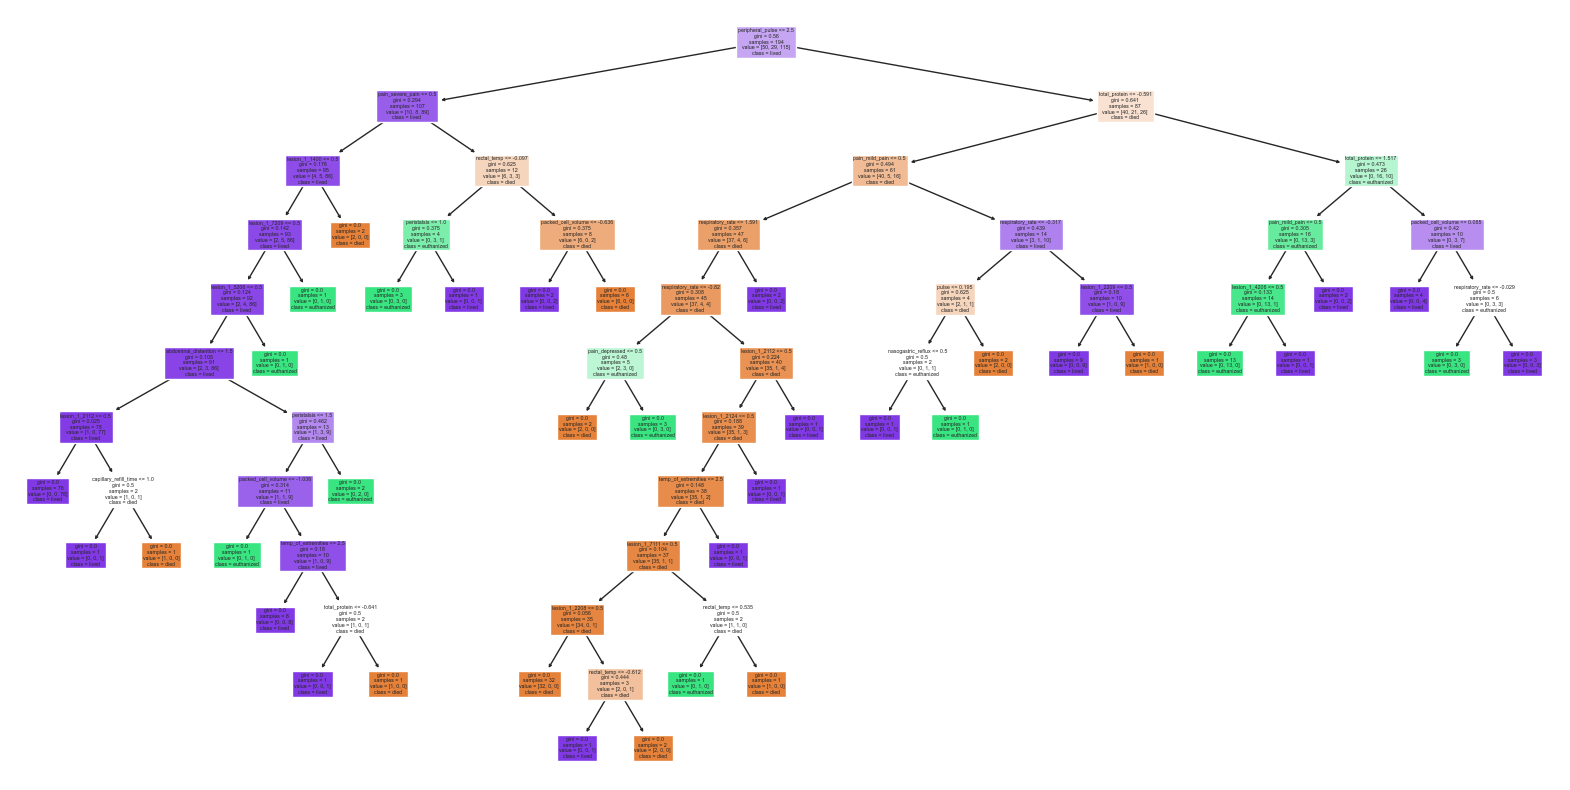

In [140]:
from sklearn.tree import plot_tree

# Plot del árbol de decisión
plt.figure(figsize=(20,10))
plot_tree(best_tree_model, feature_names=X_train.columns, class_names=['died', 'euthanized', 'lived'], filled=True)
plt.show()

Decidimos recurrir a la técnica de poda por complejidad de costo (CCP) O "Cost Complexity Pruning", la cual incorpora al hiperparámetro ccp_alpha que mide la profundidad de la poda a partir de la complejidad aportada por cada nodo adicional.

Este hiperparámetro será optimizado por GridSearch Cross Validation.

In [141]:
# Obtener el camino de poda por complejidad de costo
path = best_tree_model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Inicializar una lista para almacenar los modelos podados
pruned_trees = []

# Para cada valor de ccp_alpha, entrenar un árbol y añadirlo a la lista
for ccp_alpha in ccp_alphas:
    pruned_tree = DecisionTreeClassifier(random_state=1, ccp_alpha=ccp_alpha)
    pruned_tree.fit(X_train, y_train)
    pruned_trees.append(pruned_tree)

# Encontrar el índice del mejor valor de ccp_alpha que maximiza la precisión en los datos de prueba
test_accuracies = [pruned_tree.score(X_test, y_test) for pruned_tree in pruned_trees]
best_alpha_index = np.argmax(test_accuracies)
best_alpha = ccp_alphas[best_alpha_index]

# Entrenar un nuevo árbol con el mejor valor de ccp_alpha
pruned_tree_best = DecisionTreeClassifier(random_state=1, ccp_alpha=best_alpha)
pruned_tree_best.fit(X_train, y_train)

# Realizar predicciones en los datos de prueba utilizando el árbol podado
y_pred_pruned = pruned_tree_best.predict(X_test)

print("Mejor valor de ccp_alpha:", best_alpha)
print("Hiperparámetros del árbol podado con el mejor valor de ccp_alpha:")
print(pruned_tree_best.get_params())

Mejor valor de ccp_alpha: 0.009964414811438416
Hiperparámetros del árbol podado con el mejor valor de ccp_alpha:
{'ccp_alpha': 0.009964414811438416, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 1, 'splitter': 'best'}


Accuracy = 72.39999999999999%
F1 Score = 71.39999999999999%

 Confusion Matrix:
 [[15  1 11]
 [ 1  7  7]
 [ 6  3 54]]

Classification Report:
               precision    recall  f1-score   support

        died       0.68      0.56      0.61        27
  euthanized       0.64      0.47      0.54        15
       lived       0.75      0.86      0.80        63

    accuracy                           0.72       105
   macro avg       0.69      0.63      0.65       105
weighted avg       0.72      0.72      0.71       105



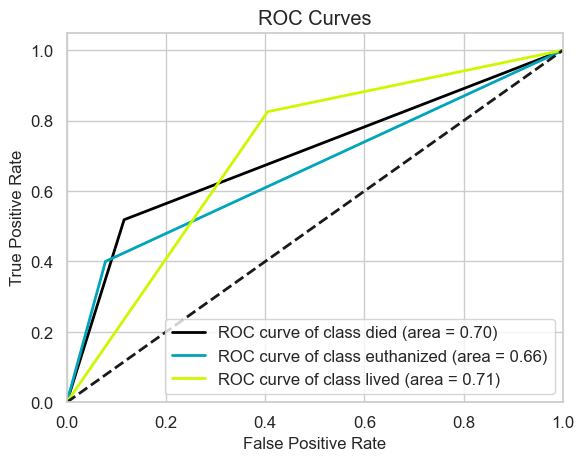

In [142]:
# Función resumen resultados
Classification_Summary(y_pred_pruned, pred_prob_tree, 3)

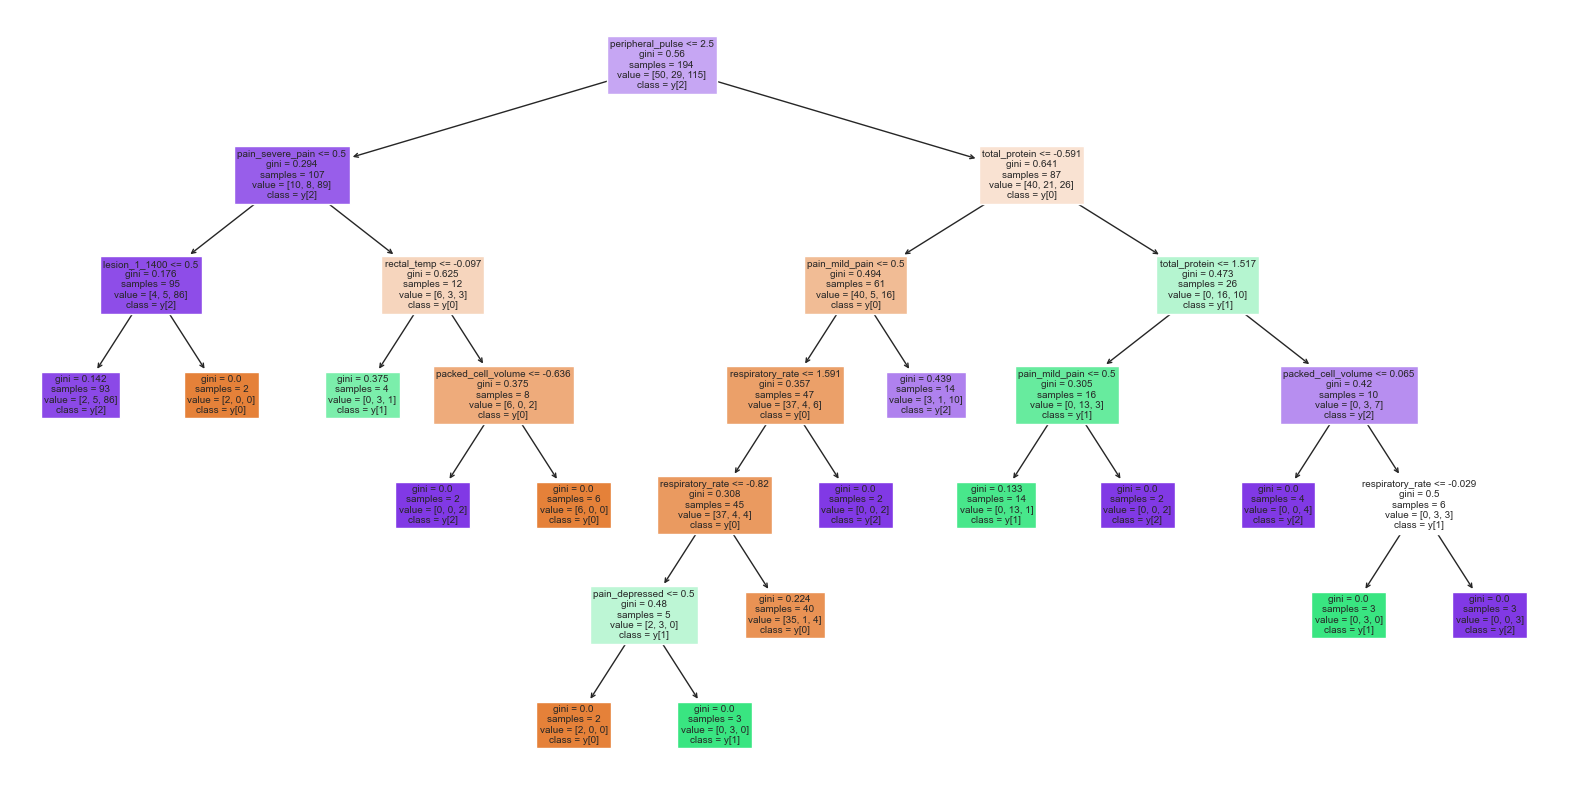

In [143]:
plt.figure(figsize=(20, 10))
plot_tree(pruned_tree_best, filled=True, feature_names=X_train.columns, class_names=True)
plt.show()

Conclusión: 

El modelo de árbol de decisión simple no fue particularmente eficiente en predecir las categorías de interés. Logramos mejorar las métricas generales del mismo, así como los valores de recall y f1-score para "Died" y "Euthanized" a través de la poda. Los gráficos pre y post-poda son especialmente elocuentes en cuanto a la reducción del sobreajuste de este modelo que logramos a través de esta operación.

##### Balanced Random Forest para observar si es posible mejorar el recall de la clase "euthanized"
---

In [144]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [145]:
start_time, memory_before = start_evaluation()

Mejores parámetros encontrados:
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 5, 'criterion': 'entropy'}
Parámetros seleccionados del modelo Balanced Random Forest:
{'bootstrap': 'warn', 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'replacement': 'warn', 'sampling_strategy': 'warn', 'verbose': 0, 'warm_start': False}

Matriz de Confusión:
[[22  1  4]
 [ 4  9  2]
 [ 6  6 51]]

Informe de Clasificación:
              precision    recall  f1-score   support

        died       0.69      0.81      0.75        27
  euthanized       0.56      0.60      0.58        15
       lived       0.89      0.81      0.85        63

    accuracy               

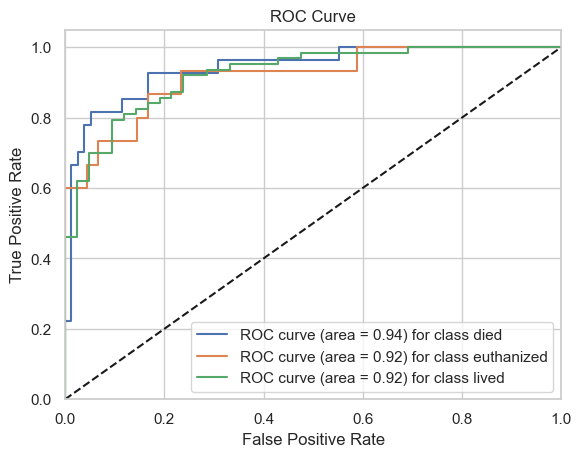

In [146]:
params = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Instanciamos el modelo y configuramos la CV
balanced_rf_model = BalancedRandomForestClassifier(random_state=1)
balanced_rf_RCV = RandomizedSearchCV(balanced_rf_model, params, scoring='roc_auc', n_jobs=-1, cv=cv)

# Fit a datos de entrenamiento
balanced_rf_RCV.fit(X_train, y_train)

# Cross-validation
best_balanced_rf_model = balanced_rf_RCV.best_estimator_
print("Mejores parámetros encontrados:")
print(balanced_rf_RCV.best_params_)

# Predicciones
y_pred_best_balanced_rf = best_balanced_rf_model.predict(X_test)
y_test_bin = label_binarize(y_test, classes=best_balanced_rf_model.classes_)
pred_prob_best_balanced_rf = best_balanced_rf_model.predict_proba(X_test)

# En este caso no pudimos aplicar la función creada para los resultados de los otros modelos, por lo cual la generamos manualmente
print("Parámetros seleccionados del modelo Balanced Random Forest:")
print(balanced_rf_model.get_params())

print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred_best_balanced_rf))

print("\nInforme de Clasificación:")
print(classification_report(y_test, y_pred_best_balanced_rf))

# ROC
def roc_auc(y_true, probas):
    classes = best_balanced_rf_model.classes_
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], probas[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:0.2f}) for class {classes[i]}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

roc_auc(y_test_bin, pred_prob_best_balanced_rf)


In [147]:
end_evaluation(start_time, memory_before, balanced_rf_model, X_test)

Tiempo de entrenamiento: 86.36199474334717 segundos
Uso de memoria antes del entrenamiento: 295052.0 KB
Uso de memoria después del entrenamiento: 296580.0 KB
Tamaño del modelo: 4.57763671875e-05 MB


##### Comparación de modelos - Árbol de decisión vs. Balanced Random Forest
---

El modelo Balanced Random Forest presenta una accuracy y F1 generales aceptables, con un mejor desempeño en términos de recall para la clase 'Euthanized' e igual en la clase "Died" con respecto a la Regresión Logística seleccionada (y muy superiores con respecto al árbol de decisión anterior). Con respecto al árbol anterior, requirió más tiempo para ensayar hiperparámetros, por lo cual recurrimos a Randomized Search para realizar una validación cruzada más eficiente. Sin embargo, exhibe una precisión mayor para todas las clases y un mejor F1, así como valores de AUC.